#### DISCLAIMER:  For this lab, we only had no more than one week to work on it, and the contents of the Deep and Wide Networks are explained in only one small lecture and the slides were not any elaborate at all, same for cross validation and evaluation stuff, we didn't really dig into this topic such as the past ones and thus there was a lot of time on us the students to research and learn this. And with this lab only being published one week before the deadline, that made it really hard for us to manage to learn everything or satisfy all the requirements for this lab. So, hope you fogive the numerous times I say below that "We will need to investigate this further if we have time" because we wanted to have something complete to submit first then introduce modifications. Thus, we are not satisfied with any of the accuracy/precision scores below and we CAN make it better, if not for the very tight deadline for this particular lab. Thank you!

# Lab Assignment Five: Wide and Deep Network Architectures

In this lab, we will select a prediction task to perform on our dataset, evaluate two different deep learning architectures and tune hyper-parameters for each architecture.

## Team Members:
1) Mohammed Ahmed Abdelrazek Aboelela.

2) Naim Barnett

## Dataset Selection

Data Set : Credit Card Classification - https://www.kaggle.com/datasets/parisrohan/credit-score-classification?select=train.csv

### Overview and Business Understanding

It is very important in the work of global financial companies and also banks to have a classifier that helps them to decide whether or not to trust customers when lending them large sum of money, such as a mortgage or a line of credit. To determine said reliability of customers, companies and banks utilizes the credit score, which is dependent on a variety of factors. Within the public domain of Kaggle, there is a large database that holds information on the known factors associated with credit score, and the final given credit score bracket. It contains over 100000 datapoints, and it utilizes both numeric and categorical data. Our goal is to build an intelligent system to segregate the people into credit score brackets to reduce the manual efforts. Thus, the main prediction task here is to classify the credit score of a customer based on their credit-related attributes. This is of direct interest to third parties (such as companies) that want a tool to reduce the efforts to classify their customer's credit scores. Consequently, for the prediction algorithm to be considered useful, it needs to be very efficient when applied to our test data in predicting the credit scores of the test customers. The model (from my own understanding of the difference between online and offline analysis) will be mostly for offline analysis, meaning that the model will be trained and tested using the already provided datapoints, and then the prediction data will be collected and fed to the algorithm that will predict the respective credit score bracket.

## Preparation

In [264]:
"""Importing all the needed packages"""
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
import re
import missingno as mn         #make sure to have the package installed "pip install missingno"
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pprint as pp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras
import os
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
print(tf.__version__)
print(keras.__version__)
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.datasets import make_classification
from sklearn import __version__ as sklearn_version
sklearn_version

2.9.1
2.9.0


'1.1.3'

In [265]:
"""Loading the dataset"""
df_train_orig = pd.read_csv('train.csv', low_memory=False)
df_train_orig.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [266]:
data = deepcopy(df_train_orig)

From the data below, we can see the overall statistics from the raw data. Ideally, once we are done cleaning, such values as the average will become more accurate.

In [267]:
#Showing the initial form of the data and their related features and averages
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,84998.0,4194.170850,3183.686167,303.645417,1625.568229,3093.745000,5957.448333,15204.633333
Num_Bank_Accounts,100000.0,17.091280,117.404834,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,100000.0,22.474430,129.057410,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,100000.0,72.466040,466.422621,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,100000.0,21.068780,14.860104,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,98035.0,27.754251,193.177339,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,100000.0,32.285173,5.116875,20.000000,28.052567,32.305784,36.496663,50.000000
Total_EMI_per_month,100000.0,1403.118217,8306.041270,0.000000,30.306660,69.249473,161.224249,82331.000000


Below is a table that includes a description of each attribute in our dataset.

| ID | Customer_ID | Month | Name | Age | SSN | Occupation | Annual_Income | Monthly_Inhand_Salary | Num_Bank_Accounts | Num_Credit_Card | Interest_Rate| Num_of_Loan | Type_of_Loan | Delay_from_due_date | Num_of_Delayed_Payments | Changed_Credit_Limit | Num_Credit_Inquiries | Credit_Mix | Outstanding_Debt | Credit_Utilization_Ratio | Credit_History_Age | Payment_of_Min_Amount | Total_EMI_per_month | Amount_invested_monthy | Payment_Behaviour | Monthly_Balance | Credit_Score |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| a unique identification of an entry | a unique identification of a person | the month of the year | the name of a person | the age of the person | the social security number of the person | the occupation of the person | the annual income of the person | the monthly base salary of a person | the number of bank accounts a person holds | the number of other credit cards held by a person | the interest rate on the credit card | the number of loans taken from the bank | the types of loan taken by a person | the average number of days delayed from the payment date | the average number of payments delayed by a person | the percentage change in credit card limit | the number of credit card inquiries | the classification of the mix of credits (the types of different credit accounts) | the remaining debt to be paid (in USD) | the utilization ratio of credit card (the sum of all your balances, divided by the sum of your cards' credit limits) | the age of credit history of the person | whether only the minimum amount was paid by the person | the monthly EMI "Equated monthly installment" payments (in USD) | the monthly amount invested by the customer (in USD) | the payment behavior of the customer (in USD) | the monthly balance amount of the customer (in USD) | the bracket of credit score (Poor, Standard, Good)|

Due to the relatively big number of attributes (27 + Credit Score), we will be more inclined to get rid of some of them if: 
1) They are not relevant to our analysis.

2) They have a big number of missing data (which make it hard to do imputation).

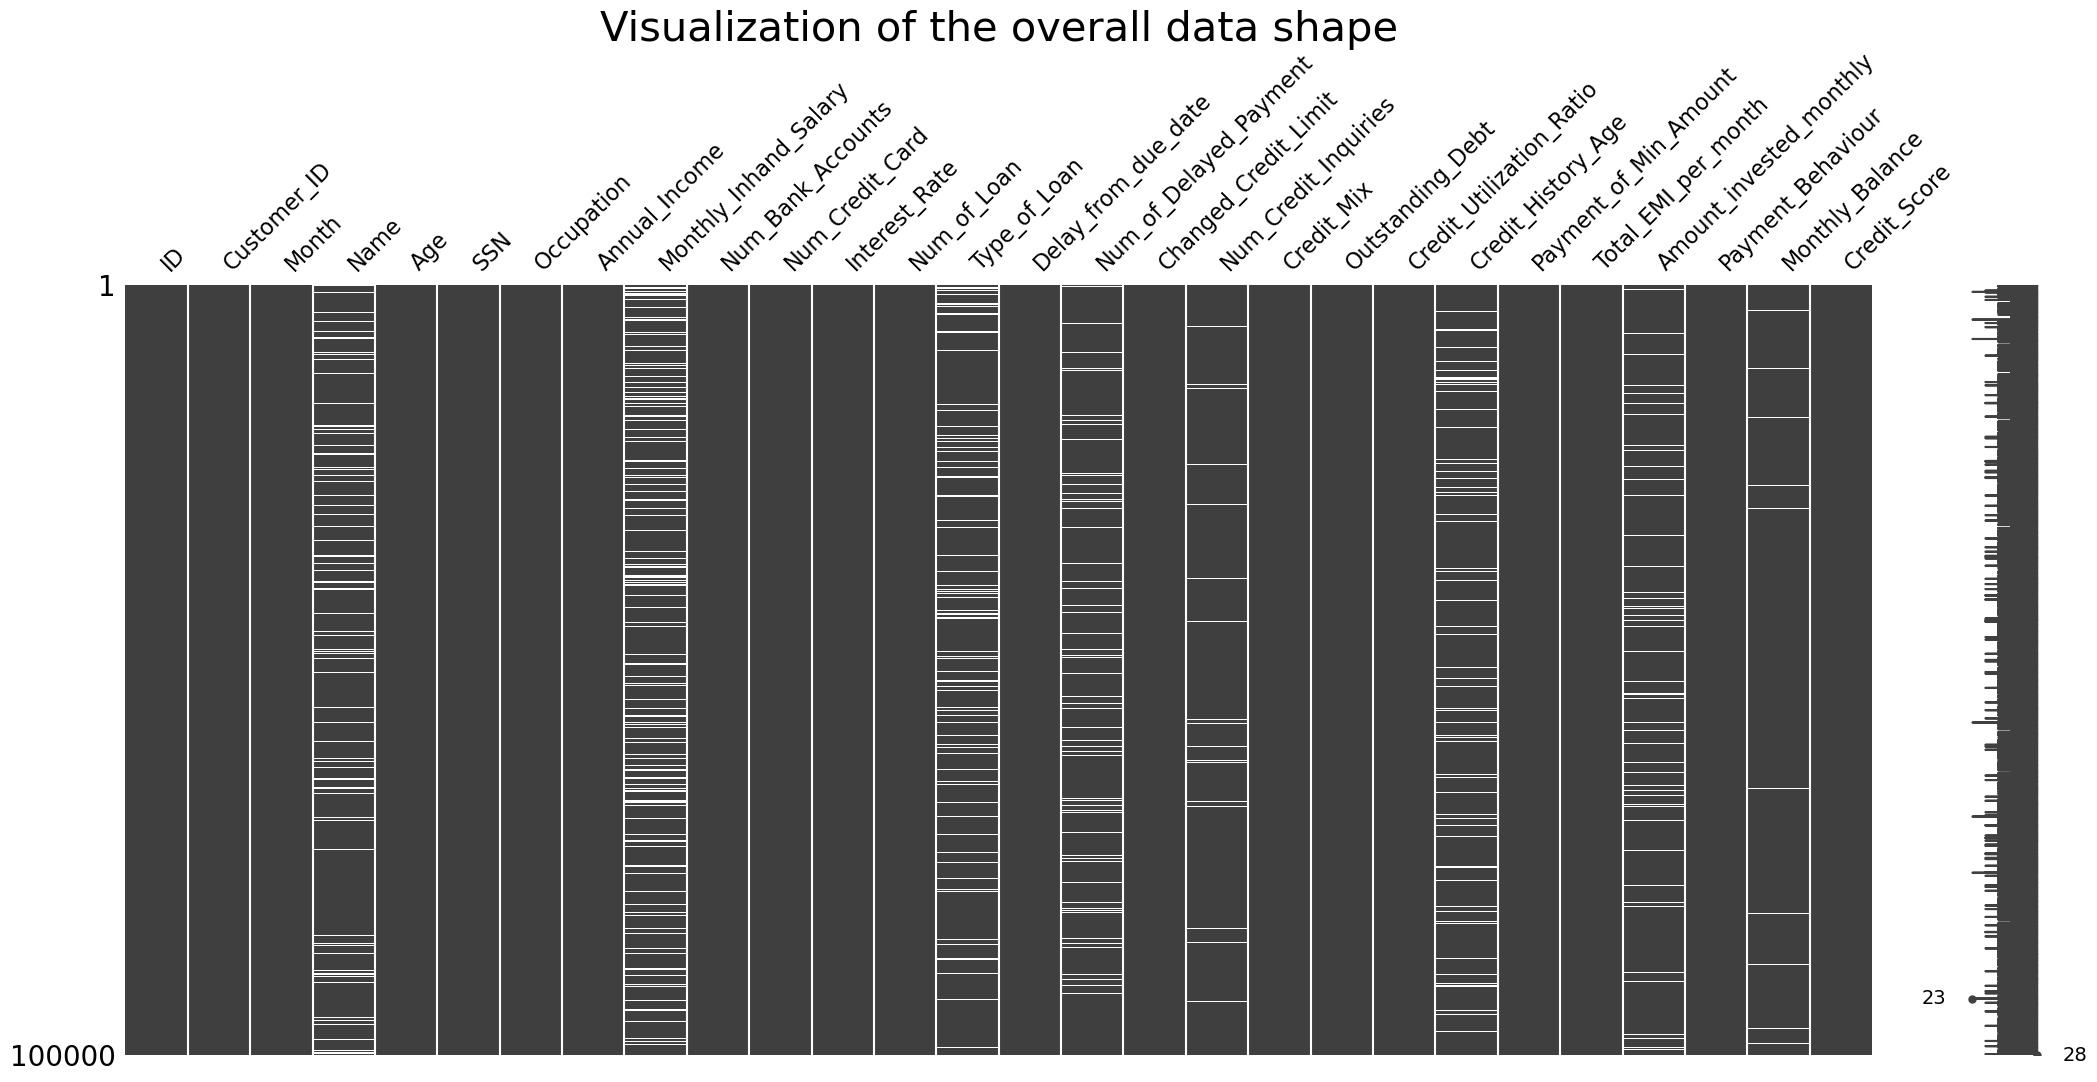

In [268]:
#Looking at the overall shape of the data
mn.matrix(data)
plt.title("Visualization of the overall data shape", fontsize=30)
plt.show()

To ensure our data maintains high quality, so our results can be as accurate as possible, we need to clean our data.

After an attempt to impute the null or unusable values, we found that it ended up skewing the values. Additionally the sheer amount of values caused overfitting in some of our calculations. Resultantly, we chose to simply remove the unusable data .

First, we are going to remove columns that are not useful to our analysis. We can see that information such as Customer_ID, Month, Name, and SSN are general information that is extremely unlikely to have any affect on the trends we are analyzing. As a result, we can remove the columns to narrow our dataset.

In [269]:
#Print column names
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [270]:
'''Remove Customer_ID, Name, SSN, Month, and Type_of_Loan. We remove the "Type_of_Loan" because it has broadly many unique values
and combinations that will be very hard to trace and will more likely make it harder for the network to find a pattern in training. We remove
Occupation because becomes a redundant feature in conjunction with "Income". "Income" is more applicable to our model.
'''

data.drop(['ID','Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Month'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  object 
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  object 
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               100000 non-null  object 
 8   Delay_from_due_date       100000 non-null  int64  
 9   Num_of_Delayed_Payment    92998 non-null   object 
 10  Changed_Credit_Limit      100000 non-null  object 
 11  Num_Credit_Inquiries      98035 non-null   float64
 12  Credit_Mix                100000 non-null  object 
 13  Outstanding_Debt          100000 non-null  ob

Secondly, we are going to fill null values in the columns missing data. We also want to remove any illegal values

In [271]:
#Replace Invalid Values
data =data.replace(r'[^\w\s.]|_|-', '', regex=True) 
#Replace all blank strings will null to be dropped
data.replace('', np.nan, inplace=True)
#Remove all rows with null values
data.dropna(inplace=True);

In [272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48251 entries, 6 to 99999
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       48251 non-null  object 
 1   Occupation                48251 non-null  object 
 2   Annual_Income             48251 non-null  object 
 3   Monthly_Inhand_Salary     48251 non-null  float64
 4   Num_Bank_Accounts         48251 non-null  int64  
 5   Num_Credit_Card           48251 non-null  int64  
 6   Interest_Rate             48251 non-null  int64  
 7   Num_of_Loan               48251 non-null  object 
 8   Delay_from_due_date       48251 non-null  int64  
 9   Num_of_Delayed_Payment    48251 non-null  object 
 10  Changed_Credit_Limit      48251 non-null  object 
 11  Num_Credit_Inquiries      48251 non-null  float64
 12  Credit_Mix                48251 non-null  object 
 13  Outstanding_Debt          48251 non-null  object 
 14  Credit

Thirdly, we want to clear out all duplicate data so our frequency analysis remains accurate.

In [273]:
#Find duplicate instances
duplicates = data[data.duplicated()]

#Remove all duplicates
data = data.drop_duplicates()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48251 entries, 6 to 99999
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       48251 non-null  object 
 1   Occupation                48251 non-null  object 
 2   Annual_Income             48251 non-null  object 
 3   Monthly_Inhand_Salary     48251 non-null  float64
 4   Num_Bank_Accounts         48251 non-null  int64  
 5   Num_Credit_Card           48251 non-null  int64  
 6   Interest_Rate             48251 non-null  int64  
 7   Num_of_Loan               48251 non-null  object 
 8   Delay_from_due_date       48251 non-null  int64  
 9   Num_of_Delayed_Payment    48251 non-null  object 
 10  Changed_Credit_Limit      48251 non-null  object 
 11  Num_Credit_Inquiries      48251 non-null  float64
 12  Credit_Mix                48251 non-null  object 
 13  Outstanding_Debt          48251 non-null  object 
 14  Credit

Fourthly, we would like to remove outliers from out dataset, so that our data analysis isn't skewed.

In [274]:
#Determine outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
#Remove outliers
data = data[~((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis = 1)]
data = data[(data['Num_Bank_Accounts'] >= 0)]

data[['Age']] = data[['Age']].apply(pd.to_numeric)
data = data.loc[(data["Age"] > 0) & (data["Age"] <= 112)] #112 is the recorded oldest age ever!

data[['Changed_Credit_Limit']] = data[['Changed_Credit_Limit']].apply(pd.to_numeric)
data = data.loc[(data["Changed_Credit_Limit"] > 0) & (data["Changed_Credit_Limit"] <= 100)] #Since it's a percentage,
#we do the selection of the instances with numbers between 0 and 100%.

data[['Monthly_Balance']] = data[['Monthly_Balance']].astype('float64')
data = data.loc[(data["Monthly_Balance"] < 10000)] #Keeping the reasonable monthly balance (value < 10000), 
#and the converting to numeric values

data = data.loc[(data["Payment_Behaviour"] != '98')] #noticed this unreasonable category thus removing it

data = data.loc[(data["Payment_of_Min_Amount"] != 'NM')] #keeping only known info about payment of min amount

data.info()

/var/folders/l3/2httnx650539mb_cn3qm_z80cc_3b_/T/ipykernel_33073/874893595.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis = 1)]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31212 entries, 6 to 99991
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       31212 non-null  int64  
 1   Occupation                31212 non-null  object 
 2   Annual_Income             31212 non-null  object 
 3   Monthly_Inhand_Salary     31212 non-null  float64
 4   Num_Bank_Accounts         31212 non-null  int64  
 5   Num_Credit_Card           31212 non-null  int64  
 6   Interest_Rate             31212 non-null  int64  
 7   Num_of_Loan               31212 non-null  object 
 8   Delay_from_due_date       31212 non-null  int64  
 9   Num_of_Delayed_Payment    31212 non-null  object 
 10  Changed_Credit_Limit      31212 non-null  float64
 11  Num_Credit_Inquiries      31212 non-null  float64
 12  Credit_Mix                31212 non-null  object 
 13  Outstanding_Debt          31212 non-null  object 
 14  Credit

Fifthly, we convert all the values that unreasonably categorical into numeric for convinience.

In [275]:
"""Converting the unreasonable categorical features to numeric"""
data[['Annual_Income']] = data[['Annual_Income']].apply(pd.to_numeric)
data[['Num_of_Loan']] = data[['Num_of_Loan']].apply(pd.to_numeric)
data[['Num_of_Delayed_Payment']] = data[['Num_of_Delayed_Payment']].apply(pd.to_numeric)
data[['Outstanding_Debt']] = data[['Outstanding_Debt']].apply(pd.to_numeric)
data[['Outstanding_Debt']] = data[['Outstanding_Debt']].apply(pd.to_numeric)
data['Credit_History_Age'] = data['Credit_History_Age'].str[:2] #Keeping the year part only
data[['Credit_History_Age']] = data[['Credit_History_Age']].apply(pd.to_numeric)
data[['Amount_invested_monthly']] = data[['Amount_invested_monthly']].apply(pd.to_numeric)

In [276]:
data.reset_index()

,index,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,6,23,Scientist,19114.12,1824.843333,3,4,3,4,3,...,Good,809.98,22.537593,22,No,49.574949,178.344067,LowspentSmallvaluepayments,244.565317,Good
1,9,28,Teacher,34847.84,3037.986667,2,4,6,1,7,...,Good,605.03,38.550848,26,No,18.816215,40.391238,HighspentLargevaluepayments,484.591214,Good
2,12,28,Teacher,34847.84,3037.986667,2,4,6,1,3,...,Good,605.03,34.977895,26,No,18.816215,130.115420,LowspentSmallvaluepayments,444.867032,Good
3,13,28,Teacher,34847.84,3037.986667,2,4,6,1,3,...,Good,605.03,33.381010,27,No,18.816215,43.477190,HighspentLargevaluepayments,481.505262,Good
4,15,28,Teacher,34847.84,3037.986667,2,4,6,1,3,...,Good,605.03,32.933856,27,No,18.816215,218.904344,LowspentSmallvaluepayments,356.078109,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31207,99976,49,Writer,37188.10,3097.008333,1,4,5,3,7,...,Good,620.64,39.080823,29,No,84.205949,223.875018,LowspentSmallvaluepayments,291.619866,Good
31208,99977,49,Writer,37188.10,3097.008333,1,4,5,3,7,...,Good,620.64,32.803431,29,No,84.205949,70.869970,HighspentLargevaluepayments,394.624914,Good
31209,99984,28,Architect,20002.88,1929.906667,10,8,29,5,35,...,Bad,3571.70,22.895966,5,Yes,60.964772,43.370670,HighspentLargevaluepayments,328.655224,Poor
31210,99986,28,Architect,20002.88,1929.906667,10,8,29,5,33,...,Bad,3571.70,24.713861,5,Yes,60.964772,76.282793,LowspentSmallvaluepayments,345.743101,Poor


In [277]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31212 entries, 6 to 99991
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       31212 non-null  int64  
 1   Occupation                31212 non-null  object 
 2   Annual_Income             31212 non-null  float64
 3   Monthly_Inhand_Salary     31212 non-null  float64
 4   Num_Bank_Accounts         31212 non-null  int64  
 5   Num_Credit_Card           31212 non-null  int64  
 6   Interest_Rate             31212 non-null  int64  
 7   Num_of_Loan               31212 non-null  int64  
 8   Delay_from_due_date       31212 non-null  int64  
 9   Num_of_Delayed_Payment    31212 non-null  int64  
 10  Changed_Credit_Limit      31212 non-null  float64
 11  Num_Credit_Inquiries      31212 non-null  float64
 12  Credit_Mix                31212 non-null  object 
 13  Outstanding_Debt          31212 non-null  float64
 14  Credit

Our clean data then becomes: 

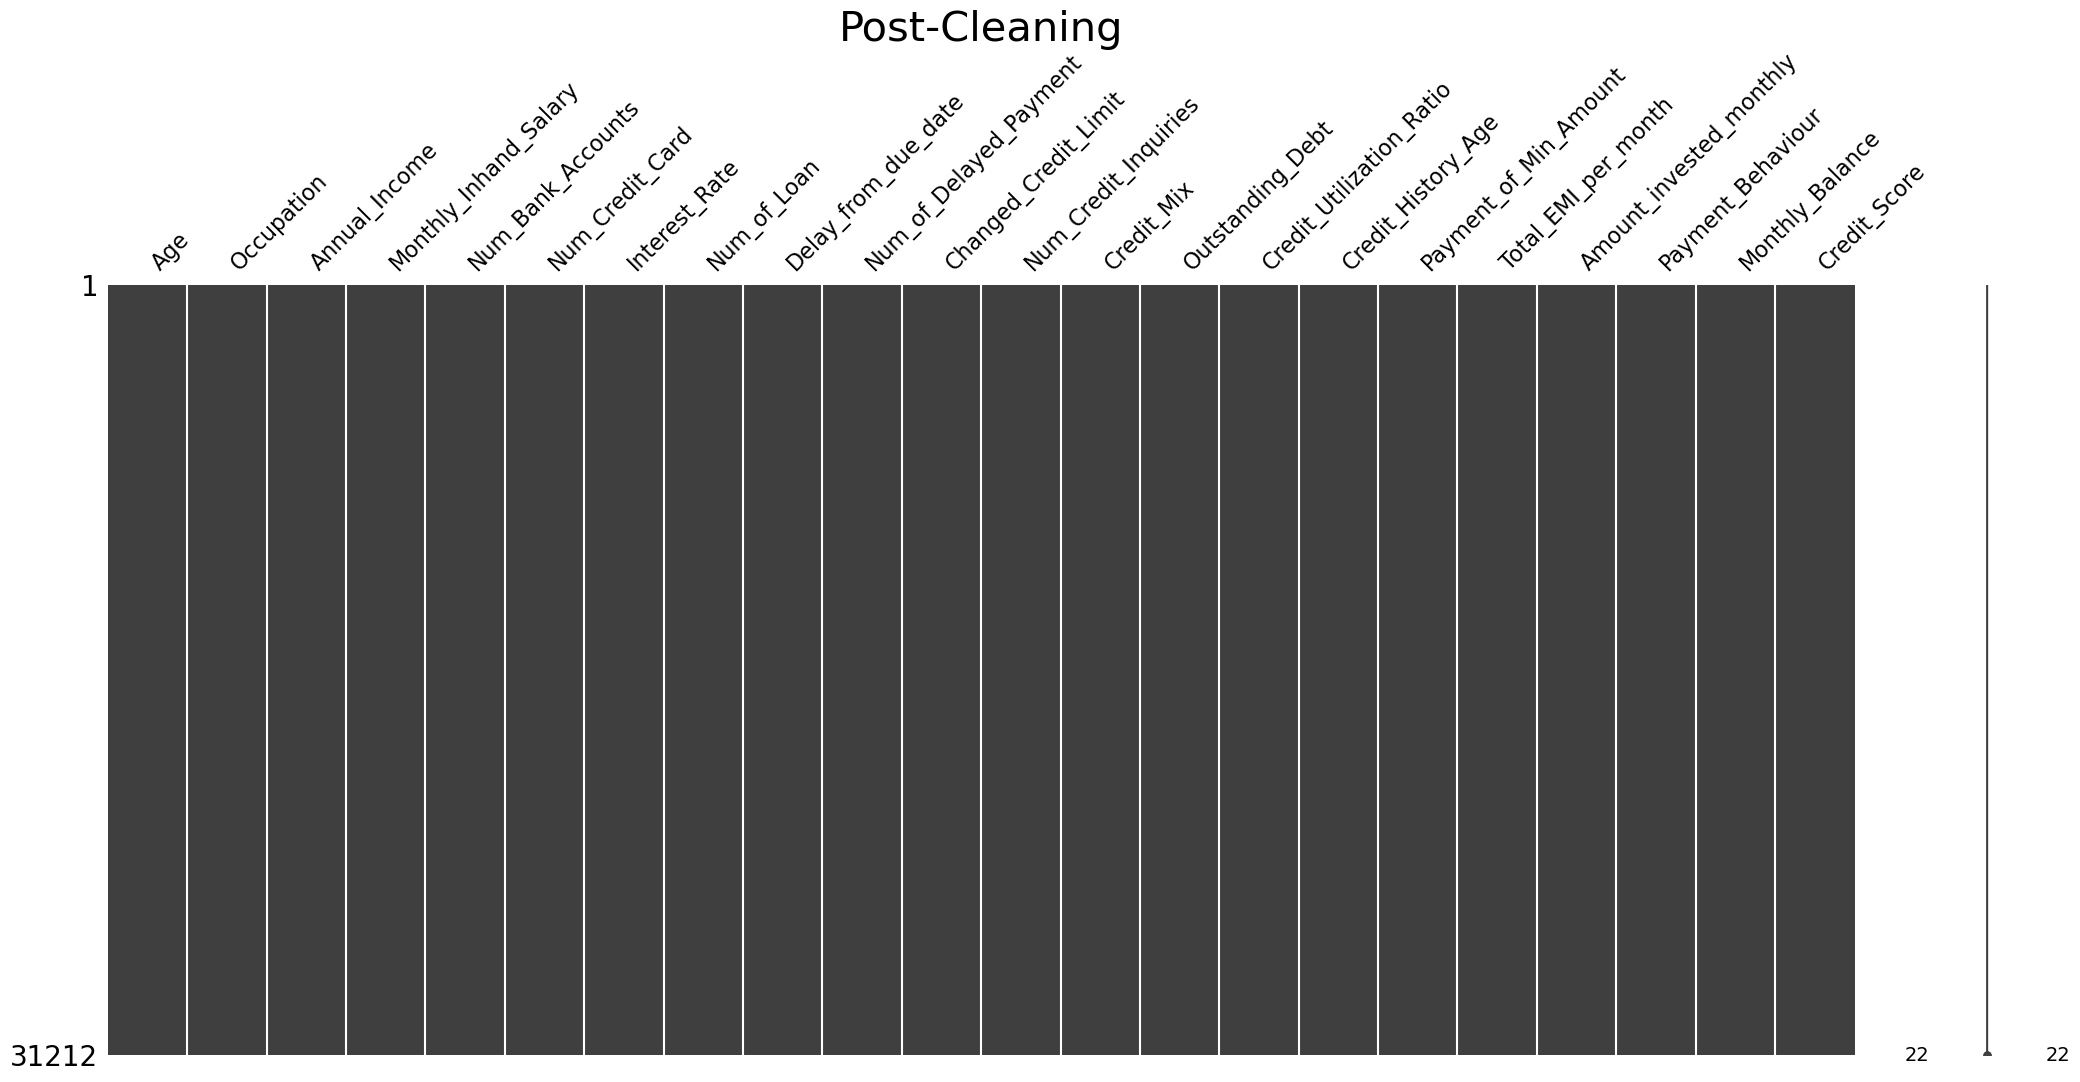

In [278]:
mn.matrix(data)
plt.title("Post-Cleaning", fontsize=30)
plt.show()

In [279]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,31212.0,33.448193,1.085276e+01,14.000000,24.000000,33.000000,42.000000,1.000000e+02
Annual_Income,31212.0,180542.282108,1.468051e+06,7005.930000,19148.930000,35544.225000,68948.320000,2.419806e+07
Monthly_Inhand_Salary,31212.0,3906.756221,2.855226e+03,303.645417,1599.524045,2948.605833,5633.435000,1.237682e+04
Num_Bank_Accounts,31212.0,5.307766,2.552675e+00,0.000000,3.000000,5.000000,7.000000,1.100000e+01
Num_Credit_Card,31212.0,5.482090,2.027122e+00,0.000000,4.000000,5.000000,7.000000,1.100000e+01
Interest_Rate,31212.0,14.198610,8.560695e+00,1.000000,7.000000,13.000000,20.000000,3.400000e+01
Num_of_Loan,31212.0,10.706203,6.223238e+01,0.000000,2.000000,3.000000,5.000000,1.480000e+03
Delay_from_due_date,31212.0,19.679578,1.289328e+01,-5.000000,10.000000,17.000000,27.000000,5.500000e+01
Num_of_Delayed_Payment,31212.0,31.739876,2.327606e+02,0.000000,9.000000,14.000000,18.000000,4.397000e+03
Changed_Credit_Limit,31212.0,10.437920,6.537392e+00,0.010000,5.470000,9.470000,14.680000,3.629000e+01


Checking categorical variables, grouping them and also grouping the numerical ones together.

In [280]:
categorical_vars = []
numerical_vars = []
for column in data.columns:
    if data[column].dtype == 'object' and column != "Credit_Score":
        categorical_vars.append(column)
    else:
        if column != "Credit_Score": numerical_vars.append(column)
        
print("The categorical variables in our cleaned dataset are:", categorical_vars)
print("The numerical variables in our cleaned dataset are:", numerical_vars)

The categorical variables in our cleaned dataset are: ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
The numerical variables in our cleaned dataset are: ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']


Performing the usual standard scaling on numerical features.

In [281]:
ss = StandardScaler()
data[numerical_vars] = ss.fit_transform(data[numerical_vars].values)
data.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
6,-0.962738,Scientist,-0.109963,-0.729170,-0.904072,-0.731142,-1.308163,-0.107762,-1.293685,-0.101994,...,Good,-0.501653,-1.918360,0.457913,No,-0.459180,-0.214063,LowspentSmallvaluepayments,-0.768761,Good
9,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-0.983441,-0.132069,...,Good,-0.685087,1.240930,0.946271,No,-0.848516,-0.282379,HighspentLargevaluepayments,0.453026,Good
12,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,-0.132069,...,Good,-0.685087,0.536014,0.946271,No,-0.848516,-0.237947,LowspentSmallvaluepayments,0.250820,Good
13,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,-0.136365,...,Good,-0.685087,0.220961,1.068360,No,-0.848516,-0.280850,HighspentLargevaluepayments,0.437317,Good
15,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,-0.119180,...,Good,-0.685087,0.132741,1.068360,No,-0.848516,-0.193978,LowspentSmallvaluepayments,-0.201136,Good


In [282]:
#COME BACK LATER IF WE HAVE TIME
"""Creating a heatmap to see which numerical variables are mostly correlated to help in dimensionality reduction (if we will do it)"""
#sns.heatmap(data.corr(),annot=True)
#plt.show()

'Creating a heatmap to see which numerical variables are mostly correlated to help in dimensionality reduction (if we will do it)'

In [283]:
data["Credit_Score"].value_counts()

Standard    17160
Poor         8743
Good         5309
Name: Credit_Score, dtype: int64

Encoding the categorical features as integers using the label encoder from scikit learn.

In [352]:
"""CHECK ONE-HOT ENCODING INSTEAD OF NORMAL ENCODER LATER HERE IF YOU HAVE TIME"""

'CHECK ONE-HOT ENCODING INSTEAD OF NORMAL ENCODER LATER HERE IF YOU HAVE TIME'

In [284]:
# define objects that can encode each variable as integer    
encoders = dict() # save each encoder in dictionary
# train all encoders (special case the target 'income')
for col in categorical_vars+['Credit_Score']:
    data[col] = data[col].str.strip()
    
    if col=="Credit_Score":
        # special case the target, just replace the column
        tmp = LabelEncoder()
        data[col] = tmp.fit_transform(data[col])
    else:
        # integer encode strings that are features
        encoders[col] = LabelEncoder() # save the encoder
        data[col+'_int'] = encoders[col].fit_transform(data[col])
        

#Container for the names of our categorical encoded features
categorical_vars_ints = [x+'_int' for x in categorical_vars]

#Collecting together the features we will be interested in using later
feature_columns = categorical_vars_ints+numerical_vars

print(f"We will use the following {len(feature_columns)} features:")
pp.pprint(feature_columns)

We will use the following 21 features:
['Occupation_int',
 'Credit_Mix_int',
 'Payment_of_Min_Amount_int',
 'Payment_Behaviour_int',
 'Age',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Monthly_Balance']


In [285]:
data.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Occupation_int,Credit_Mix_int,Payment_of_Min_Amount_int,Payment_Behaviour_int
6,-0.962738,Scientist,-0.109963,-0.729170,-0.904072,-0.731142,-1.308163,-0.107762,-1.293685,-0.101994,...,No,-0.459180,-0.214063,LowspentSmallvaluepayments,-0.768761,0,12,1,0,5
9,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-0.983441,-0.132069,...,No,-0.848516,-0.282379,HighspentLargevaluepayments,0.453026,0,13,1,0,0
12,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,-0.132069,...,No,-0.848516,-0.237947,LowspentSmallvaluepayments,0.250820,0,13,1,0,5
13,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,-0.136365,...,No,-0.848516,-0.280850,HighspentLargevaluepayments,0.437317,0,13,1,0,0
15,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,-0.119180,...,No,-0.848516,-0.193978,LowspentSmallvaluepayments,-0.201136,0,13,1,0,5


In [286]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31212 entries, 6 to 99991
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        31212 non-null  float64
 1   Occupation                 31212 non-null  object 
 2   Annual_Income              31212 non-null  float64
 3   Monthly_Inhand_Salary      31212 non-null  float64
 4   Num_Bank_Accounts          31212 non-null  float64
 5   Num_Credit_Card            31212 non-null  float64
 6   Interest_Rate              31212 non-null  float64
 7   Num_of_Loan                31212 non-null  float64
 8   Delay_from_due_date        31212 non-null  float64
 9   Num_of_Delayed_Payment     31212 non-null  float64
 10  Changed_Credit_Limit       31212 non-null  float64
 11  Num_Credit_Inquiries       31212 non-null  float64
 12  Credit_Mix                 31212 non-null  object 
 13  Outstanding_Debt           31212 non-null  flo

In [287]:
# we have the following lists now of data that we can use with our dataframes:
print("Numeric Headers:")
pp.pprint(numerical_vars) # normalized numeric data
print("\nCategorical String Headers:")
pp.pprint(categorical_vars) # string data
print("\nCategorical Headers, Encoded as Integer:")
pp.pprint(categorical_vars_ints) # string data encoded as an integer

Numeric Headers:
['Age',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Monthly_Balance']

Categorical String Headers:
['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

Categorical Headers, Encoded as Integer:
['Occupation_int',
 'Credit_Mix_int',
 'Payment_of_Min_Amount_int',
 'Payment_Behaviour_int']


Thus, the final pre-processed clean dataset we have consists of 31,212 instances. It has 17 numerical features that are ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'] and 4 categorical ones ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']. The task is to perform a classification and predict the target variable that is ['Credit_Score'], which is encoded too using the same label encoder

In [288]:
# sandbox for looking at different categorical variables
for col in categorical_vars:
    vals = data[col].unique()
    print(col,'has', len(vals), 'unique values:')
    print(vals)

Occupation has 15 unique values:
['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician' 'MediaManager'
 'Mechanic' 'Architect' 'Writer']
Credit_Mix has 3 unique values:
['Good' 'Standard' 'Bad']
Payment_of_Min_Amount has 2 unique values:
['No' 'Yes']
Payment_Behaviour has 6 unique values:
['LowspentSmallvaluepayments' 'HighspentLargevaluepayments'
 'HighspentSmallvaluepayments' 'HighspentMediumvaluepayments'
 'LowspentLargevaluepayments' 'LowspentMediumvaluepayments']


We will now look to combine related features into cross-product features.

In [289]:
# choose these as a class, what makes sense
cross_columns = ['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

In [290]:
"""Investigating the crossed columns"""
cols_list = cross_columns

# 1. create crossed labels by string join operation
X_crossed_train = X_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
X_crossed_test = X_test[cols_list].apply(lambda x: '_'.join(x), axis=1)

# combine together for training
all_vals = np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy()))
print(np.unique(all_vals))
    
# 2. encode as integers, stacking all possibilities
enc = LabelEncoder()
enc.fit(all_vals)

encoded_vals_train = enc.transform(X_crossed_train)
encoded_vals_test  = enc.transform(X_crossed_test)

print(np.min(encoded_vals_train), np.max(encoded_vals_train))

['Bad_Yes_HighspentLargevaluepayments'
 'Bad_Yes_HighspentMediumvaluepayments'
 'Bad_Yes_HighspentSmallvaluepayments'
 'Bad_Yes_LowspentLargevaluepayments'
 'Bad_Yes_LowspentMediumvaluepayments'
 'Bad_Yes_LowspentSmallvaluepayments'
 'Good_No_HighspentLargevaluepayments'
 'Good_No_HighspentMediumvaluepayments'
 'Good_No_HighspentSmallvaluepayments'
 'Good_No_LowspentLargevaluepayments'
 'Good_No_LowspentMediumvaluepayments'
 'Good_No_LowspentSmallvaluepayments'
 'Standard_No_HighspentLargevaluepayments'
 'Standard_No_HighspentMediumvaluepayments'
 'Standard_No_HighspentSmallvaluepayments'
 'Standard_No_LowspentLargevaluepayments'
 'Standard_No_LowspentMediumvaluepayments'
 'Standard_No_LowspentSmallvaluepayments'
 'Standard_Yes_HighspentLargevaluepayments'
 'Standard_Yes_HighspentMediumvaluepayments'
 'Standard_Yes_HighspentSmallvaluepayments'
 'Standard_Yes_LowspentLargevaluepayments'
 'Standard_Yes_LowspentMediumvaluepayments'
 'Standard_Yes_LowspentSmallvaluepayments']
0 23


For our crossed columns, we chose to cross 'Credit_Mix', 'Payment_of_Min_Amount', and 'Payment_Behaviour' because we think that we can gain new knowledge by making combinations of these sort-of realated payment features. However, we see really no relevance in including the 'occupation' in any of the crossings as it does not have any reasonable relationship to customer's credit behavior or add new knowledge to what we have currently. We can also cross any two of them together later. We're going to investigate this in the modeling part

Before everything, we are going to do a small modification to our target variable. Our problem is mainly labeled as a multi-class classification, but when you actually think about, as a company, you are only concerned about knowing whether a person has a "poor" credit score or not to be able to determine whether to give them the loan or not. You don't really care whether their credit score is "Standard" or "Good" which are both deemed to be good enough to be given loans. So, this compels us to change the nature of our prediction class to a "binary" one, where we will be mainly interested in determining whether the targer variable will be "poor: 0" or "not poor:1". We implement this below.

In [291]:
data["Credit_Score"].value_counts()

2    17160
1     8743
0     5309
Name: Credit_Score, dtype: int64

In [292]:
data["Credit_Score"].replace([1,0,2],[0,1,1], inplace=True)
data["Credit_Score"].value_counts()

1    22469
0     8743
Name: Credit_Score, dtype: int64

Given our current binary classification problem, the appropriate metric we decided to use is the "Precision" metric. This reasoning behind this is that we are only interested that we maximize the true positive out of the total predicted positives (with positive = the person being predicted to be not poor, thus we will be giving money as a company). We don't really care about whether the predicted negative is true or false cause in any case, we will not be losing money if we decide against giving the loans anyway. Thus, precision which is the ratio between the true predicted positives to the total predicted positives is the right metric we will want to maximize.

In [293]:
"""Separating the features and the target variable in the dataframe"""
X, y = data[feature_columns+categorical_vars], data['Credit_Score']

In [294]:
"""Separating into testing and training samples"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

For our model, we will choose to use Stratified 10-fold cross validation to ensure we uphold an even distribution across every fold. This will allow us to train our model numerous times with a variation of training and test sets. We think Stratified 10-fold is what we want because we don't want to do shuffle splits before each iteration as Shuffle splits/StratifiedShuffleSplit might do which might result in repeated training instances in some of the iterations, as we do not have a relatively huge sample to not care about this happening.

In [295]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train, y_train)
print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


## Modeling

In what comes next, we rely heavily on the class notebook (10. Keras Wide and Deep.ipynb). We basically copy most the network architecture from there and then adapt it to our variables and then tweak it as we want it.

### First Combined Wide and Deep Network

We use this combination of cross_columns:
cross_columns = [['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour'],
                 ['Credit_Mix','Payment_of_Min_Amount'],
                 ['Credit_Mix','Payment_Behaviour'],
                 ['Payment_of_Min_Amount','Payment_Behaviour']
                ]

In [296]:
# now let's create some different crossed values
cross_columns = [['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour'],
                 ['Credit_Mix','Payment_of_Min_Amount'],
                 ['Credit_Mix','Payment_Behaviour'],
                 ['Payment_of_Min_Amount','Payment_Behaviour']
                ]


# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = X_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # Save the encoder used here for later:
    encoders[cross_col_name] = enc
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

['Credit_Mix_Payment_of_Min_Amount_Payment_Behaviour',
 'Credit_Mix_Payment_of_Min_Amount',
 'Credit_Mix_Payment_Behaviour',
 'Payment_of_Min_Amount_Payment_Behaviour']

In [297]:
X_train_crossed = X_train[cross_col_df_names].to_numpy()
X_test_crossed = X_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = X_train[categorical_vars_ints].to_numpy() 
X_test_cat = X_test[categorical_vars_ints].to_numpy() 

# and save off the numeric features
X_train_num =  X_train[numerical_vars].to_numpy()
X_test_num = X_test[numerical_vars].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_vars_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=50, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [298]:
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 4)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_165 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                                  
 tf.compat.v1.gather_166 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                           

 concat_deep_wide (Concatenate)  (None, 63)          0           ['wide_concat[0][0]',            
                                                                  'deep3[0][0]']                  
                                                                                                  
 combined (Dense)               (None, 1)            64          ['concat_deep_wide[0][0]']       
                                                                                                  
Total params: 9,238
Trainable params: 9,238
Non-trainable params: 0
__________________________________________________________________________________________________


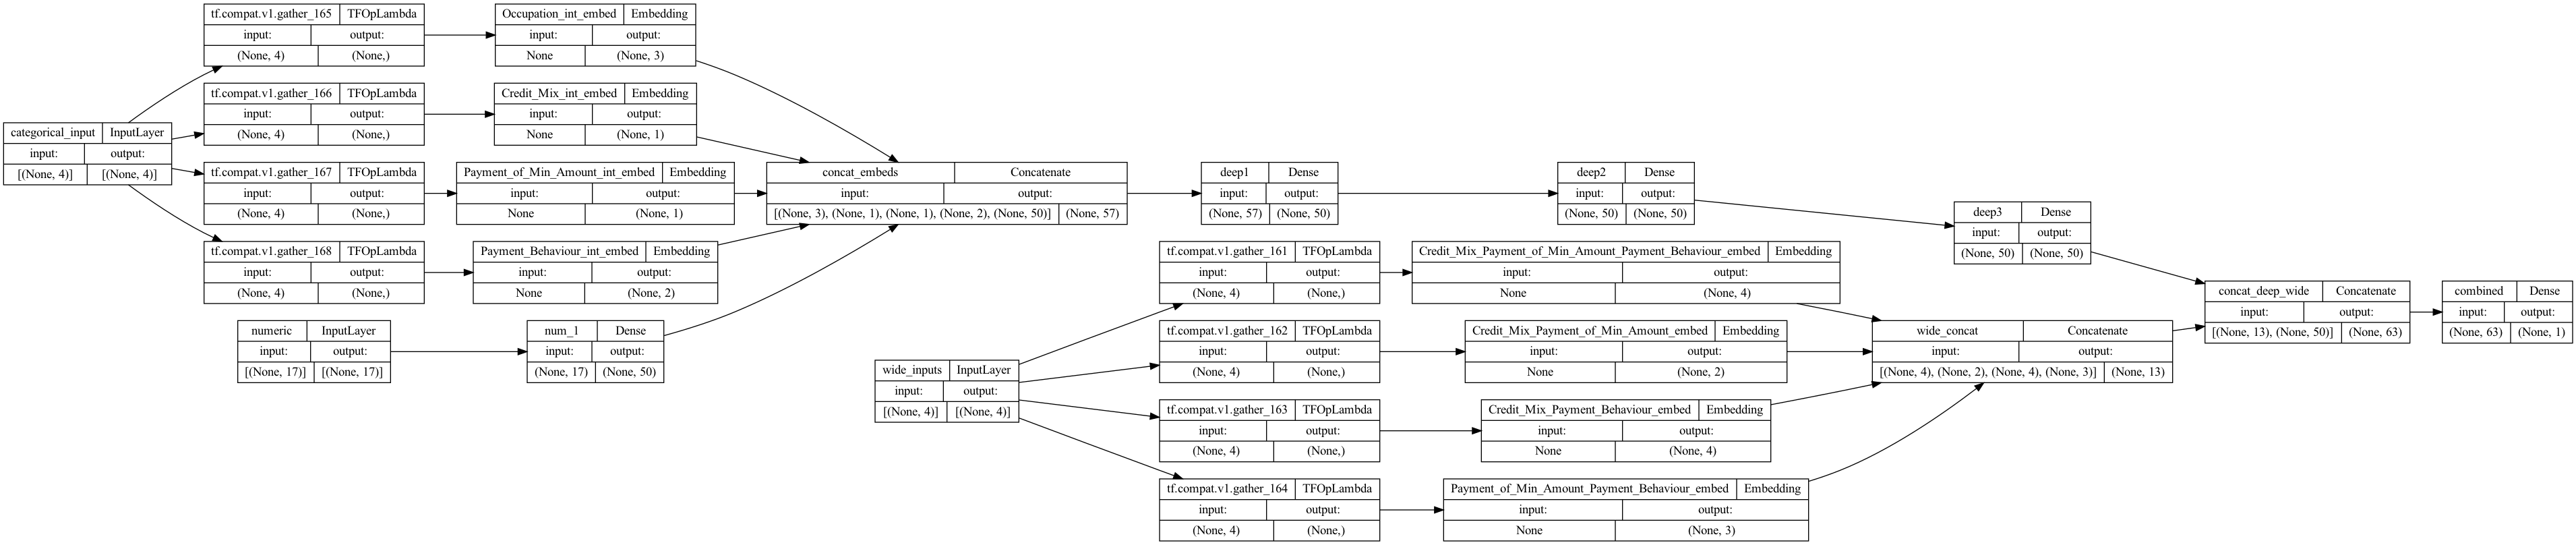

In [299]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [300]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
781/781 [==============================] - 2s 1ms/step - loss: 0.2231 - precision_22: 0.7198 - val_loss: 0.2113 - val_precision_22: 0.7198
Epoch 2/20
781/781 [==============================] - 1s 1ms/step - loss: 0.2015 - precision_22: 0.7199 - val_loss: 0.1937 - val_precision_22: 0.7198
Epoch 3/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1867 - precision_22: 0.7199 - val_loss: 0.1815 - val_precision_22: 0.7198
Epoch 4/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1766 - precision_22: 0.7200 - val_loss: 0.1730 - val_precision_22: 0.7196
Epoch 5/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1696 - precision_22: 0.7242 - val_loss: 0.1670 - val_precision_22: 0.7365
Epoch 6/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1646 - precision_22: 0.7595 - val_loss: 0.1627 - val_precision_22: 0.7776
Epoch 7/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1611 - precision_22: 0.7

In [301]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

196/196 [==============================] - 0s 636us/step
[[1002  747]
 [ 529 3965]]
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      1749
           1       0.84      0.88      0.86      4494

    accuracy                           0.80      6243
   macro avg       0.75      0.73      0.74      6243
weighted avg       0.79      0.80      0.79      6243



In [302]:
print(history.history)

{'loss': [0.22309526801109314, 0.201458141207695, 0.1867014765739441, 0.17657260596752167, 0.16956281661987305, 0.16461102664470673, 0.161074697971344, 0.15856370329856873, 0.15673236548900604, 0.1553477644920349, 0.15424206852912903, 0.15330269932746887, 0.15247833728790283, 0.15173031389713287, 0.15104132890701294, 0.15038534998893738, 0.14976440370082855, 0.14916543662548065, 0.14859087765216827, 0.14803723990917206], 'precision_22': [0.7198029160499573, 0.719892680644989, 0.719892680644989, 0.7199519276618958, 0.7241846323013306, 0.759514331817627, 0.796549379825592, 0.8162678480148315, 0.8304771780967712, 0.8360192179679871, 0.8402646780014038, 0.8420711755752563, 0.8452187180519104, 0.8469409942626953, 0.8455950021743774, 0.8473581075668335, 0.8470301032066345, 0.8476634621620178, 0.8474319577217102, 0.8470632433891296], 'val_loss': [0.21125644445419312, 0.1936582624912262, 0.1814742237329483, 0.17301538586616516, 0.1669943630695343, 0.16267342865467072, 0.15956886112689972, 0.15

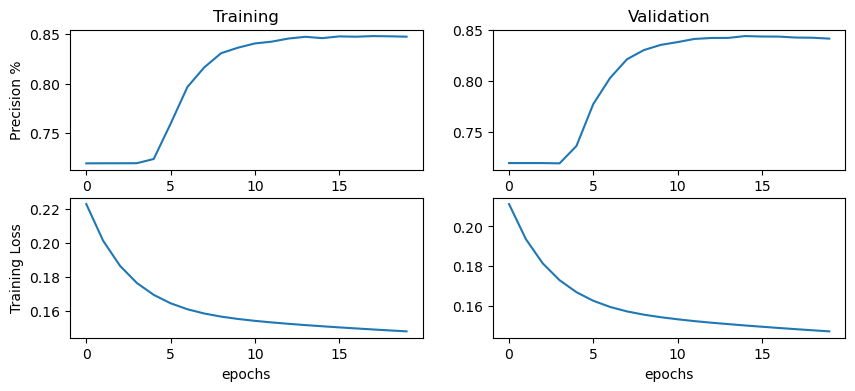

In [304]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_22'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_22'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

### Second Combined Wide and Deep Network

We will change the definition of the cross columns to be:
cross_columns = [['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']]

In [305]:
# now let's create some different crossed values
cross_columns = [['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']]


# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = X_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # Save the encoder used here for later:
    encoders[cross_col_name] = enc
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

['Credit_Mix_Payment_of_Min_Amount_Payment_Behaviour']

In [306]:
X_train_crossed = X_train[cross_col_df_names].to_numpy()
X_test_crossed = X_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = X_train[categorical_vars_ints].to_numpy() 
X_test_cat = X_test[categorical_vars_ints].to_numpy() 

# and save off the numeric features
X_train_num =  X_train[numerical_vars].to_numpy()
X_test_num = X_test[numerical_vars].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_vars_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=50, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [307]:
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 4)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_170 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                                  
 tf.compat.v1.gather_171 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                           

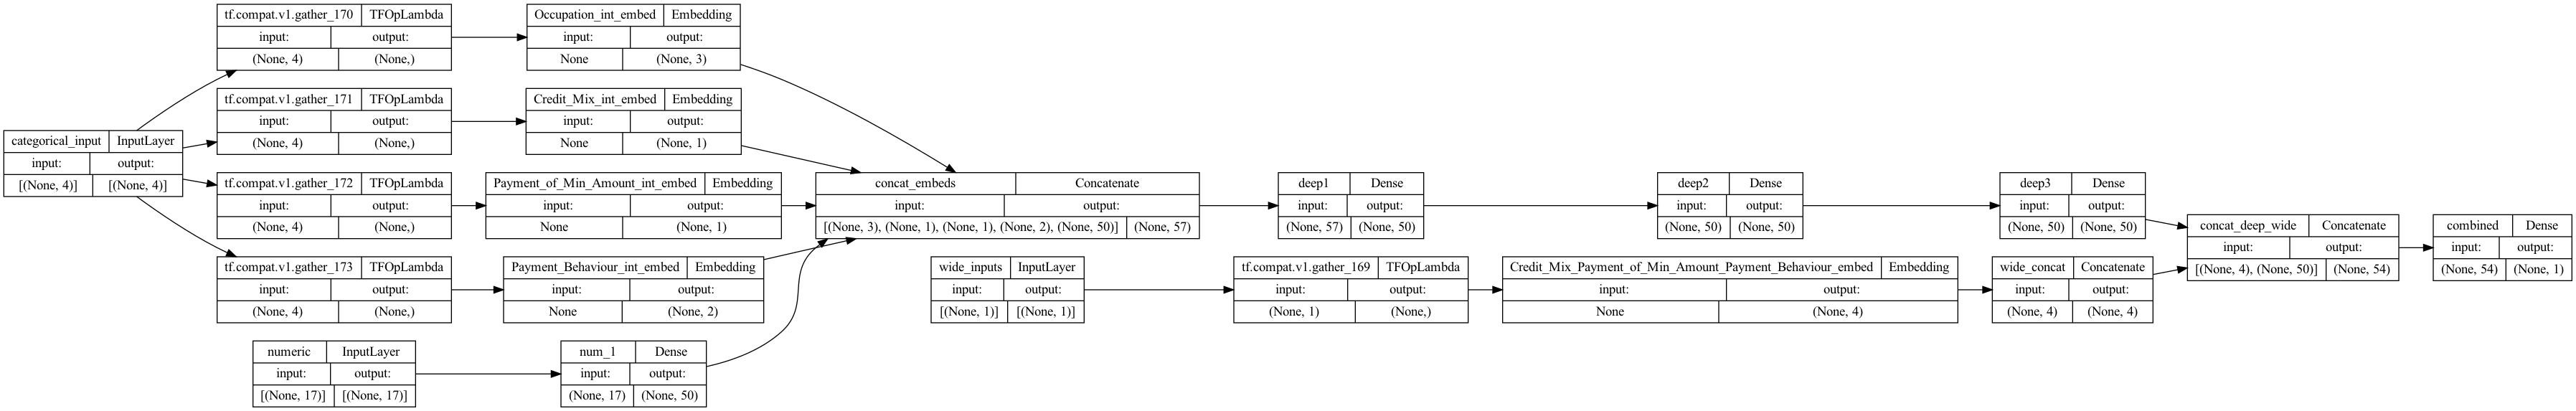

In [308]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [309]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
781/781 [==============================] - 1s 1ms/step - loss: 0.2154 - precision_23: 0.7193 - val_loss: 0.1983 - val_precision_23: 0.7198
Epoch 2/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1903 - precision_23: 0.7199 - val_loss: 0.1825 - val_precision_23: 0.7198
Epoch 3/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1783 - precision_23: 0.7199 - val_loss: 0.1736 - val_precision_23: 0.7198
Epoch 4/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1708 - precision_23: 0.7200 - val_loss: 0.1676 - val_precision_23: 0.7204
Epoch 5/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1655 - precision_23: 0.7249 - val_loss: 0.1632 - val_precision_23: 0.7326
Epoch 6/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1615 - precision_23: 0.7516 - val_loss: 0.1597 - val_precision_23: 0.7722
Epoch 7/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1585 - precision_23: 0.7

In [310]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

196/196 [==============================] - 0s 654us/step
[[ 979  770]
 [ 453 4041]]
              precision    recall  f1-score   support

           0       0.68      0.56      0.62      1749
           1       0.84      0.90      0.87      4494

    accuracy                           0.80      6243
   macro avg       0.76      0.73      0.74      6243
weighted avg       0.80      0.80      0.80      6243



In [312]:
print(history.history)

{'loss': [0.2153782844543457, 0.19025865197181702, 0.17832183837890625, 0.1707896888256073, 0.16548387706279755, 0.16152414679527283, 0.158464252948761, 0.15609559416770935, 0.1542847901582718, 0.15289586782455444, 0.15182584524154663, 0.1509529948234558, 0.15024183690547943, 0.14962513744831085, 0.14907515048980713, 0.14857330918312073, 0.14811639487743378, 0.1476864069700241, 0.1472880244255066, 0.14691497385501862], 'precision_23': [0.719300389289856, 0.719892680644989, 0.719892680644989, 0.7200143933296204, 0.7249035835266113, 0.7516461610794067, 0.7893620133399963, 0.8140836358070374, 0.8258008360862732, 0.8331936001777649, 0.8367228507995605, 0.8384774327278137, 0.8409889936447144, 0.8420182466506958, 0.8420099020004272, 0.8420211672782898, 0.8415015935897827, 0.8413127660751343, 0.8416534066200256, 0.8406584858894348], 'val_loss': [0.19831746816635132, 0.18247725069522858, 0.1736232340335846, 0.1675911396741867, 0.1631534844636917, 0.1597156673669815, 0.1570568084716797, 0.15496

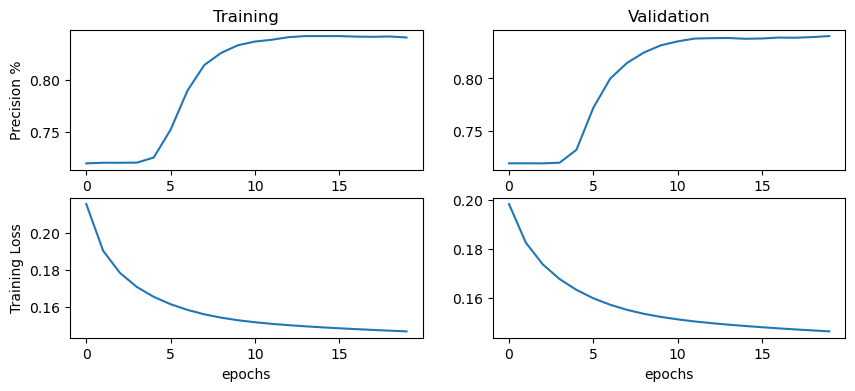

In [313]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_23'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_23'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

### Third Combined Wide and Deep Network

We change the size of the dense feature embeddings to be $log_2(N)$ instead of $\sqrt{N}$ where $N$ is the total number of uniques values.

In [314]:
# now let's create some different crossed values
cross_columns = [['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour'],
                 ['Credit_Mix','Payment_of_Min_Amount'],
                 ['Credit_Mix','Payment_Behaviour'],
                 ['Payment_of_Min_Amount','Payment_Behaviour']
                ]


# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = X_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # Save the encoder used here for later:
    encoders[cross_col_name] = enc
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

['Credit_Mix_Payment_of_Min_Amount_Payment_Behaviour',
 'Credit_Mix_Payment_of_Min_Amount',
 'Credit_Mix_Payment_Behaviour',
 'Payment_of_Min_Amount_Payment_Behaviour']

In [315]:
X_train_crossed = X_train[cross_col_df_names].to_numpy()
X_test_crossed = X_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = X_train[categorical_vars_ints].to_numpy() 
X_test_cat = X_test[categorical_vars_ints].to_numpy() 

# and save off the numeric features
X_train_num =  X_train[numerical_vars].to_numpy()
X_test_num = X_test[numerical_vars].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_vars_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N_reduced = int(np.log2(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=50, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [316]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 4)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_178 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                                  
 tf.compat.v1.gather_179 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                           

 concat_deep_wide (Concatenate)  (None, 63)          0           ['wide_concat[0][0]',            
                                                                  'deep3[0][0]']                  
                                                                                                  
 combined (Dense)               (None, 1)            64          ['concat_deep_wide[0][0]']       
                                                                                                  
Total params: 9,238
Trainable params: 9,238
Non-trainable params: 0
__________________________________________________________________________________________________


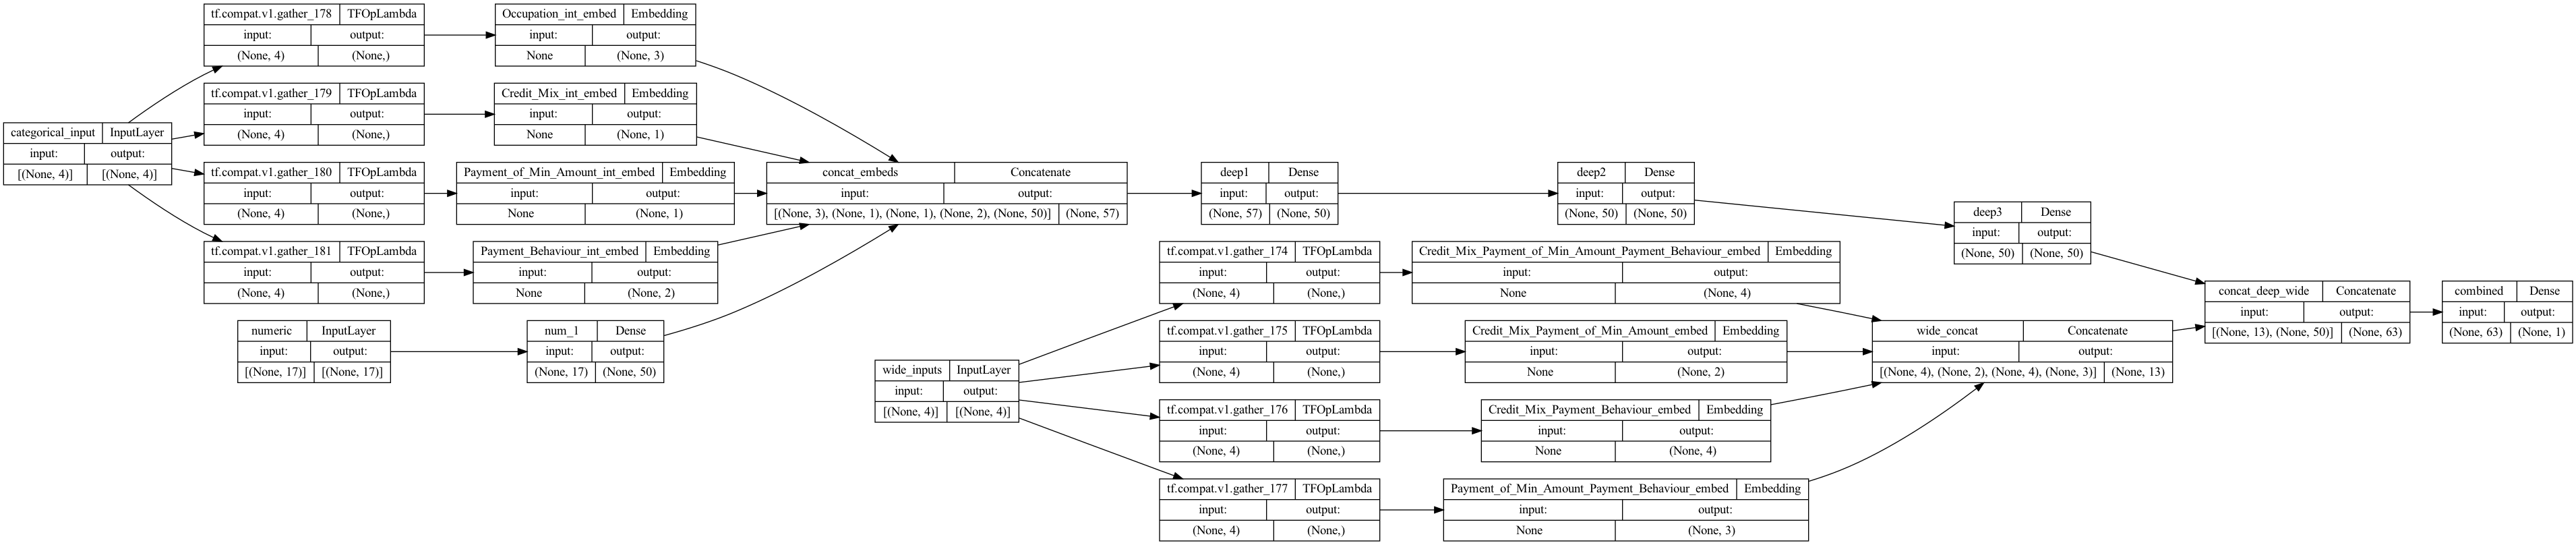

In [317]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [318]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
781/781 [==============================] - 2s 1ms/step - loss: 0.2269 - precision_24: 0.7366 - val_loss: 0.2072 - val_precision_24: 0.7201
Epoch 2/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1971 - precision_24: 0.7200 - val_loss: 0.1883 - val_precision_24: 0.7200
Epoch 3/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1833 - precision_24: 0.7202 - val_loss: 0.1780 - val_precision_24: 0.7209
Epoch 4/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1749 - precision_24: 0.7258 - val_loss: 0.1710 - val_precision_24: 0.7352
Epoch 5/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1691 - precision_24: 0.7494 - val_loss: 0.1660 - val_precision_24: 0.7635
Epoch 6/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1650 - precision_24: 0.7764 - val_loss: 0.1623 - val_precision_24: 0.7874
Epoch 7/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1620 - precision_24: 0.7

In [319]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

196/196 [==============================] - 0s 675us/step
[[ 963  786]
 [ 465 4029]]
              precision    recall  f1-score   support

           0       0.67      0.55      0.61      1749
           1       0.84      0.90      0.87      4494

    accuracy                           0.80      6243
   macro avg       0.76      0.72      0.74      6243
weighted avg       0.79      0.80      0.79      6243



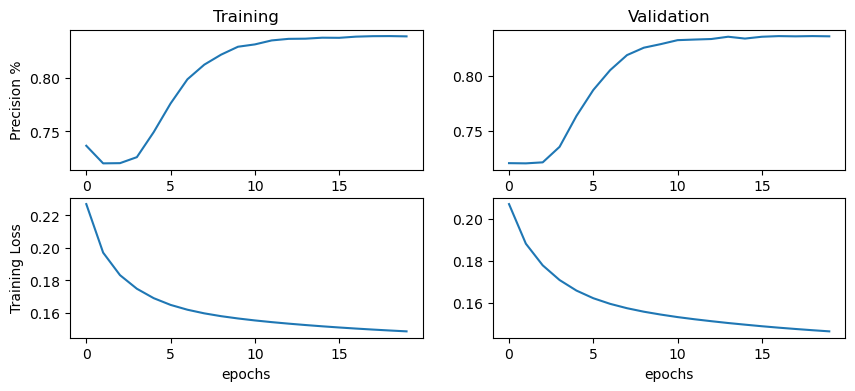

In [320]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_24'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_24'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

In [353]:
"""CHECK DIFFERENT COMBINATIONS OF CROSS COLUMNS AND ALSO PLAY WITH THE OPTIMIZER, THE NUMBER OF HIDDEN LAYERS IF YOU HAVE TIME"""

'CHECK DIFFERENT COMBINATIONS OF CROSS COLUMNS AND ALSO PLAY WITH THE OPTIMIZER, THE NUMBER OF HIDDEN LAYERS IF YOU HAVE TIME'

### Investigating generalization performance

#### Adding one more dense layer

In [321]:
X_train_crossed = X_train[cross_col_df_names].to_numpy()
X_test_crossed = X_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = X_train[categorical_vars_ints].to_numpy() 
X_test_cat = X_test[categorical_vars_ints].to_numpy() 

# and save off the numeric features
X_train_num =  X_train[numerical_vars].to_numpy()
X_test_num = X_test[numerical_vars].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_vars_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=50, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep4')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [322]:
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 4)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_186 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                                  
 tf.compat.v1.gather_187 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                           

 deep4 (Dense)                  (None, 50)           2550        ['deep3[0][0]']                  
                                                                                                  
 concat_deep_wide (Concatenate)  (None, 63)          0           ['wide_concat[0][0]',            
                                                                  'deep4[0][0]']                  
                                                                                                  
 combined (Dense)               (None, 1)            64          ['concat_deep_wide[0][0]']       
                                                                                                  
Total params: 11,788
Trainable params: 11,788
Non-trainable params: 0
__________________________________________________________________________________________________


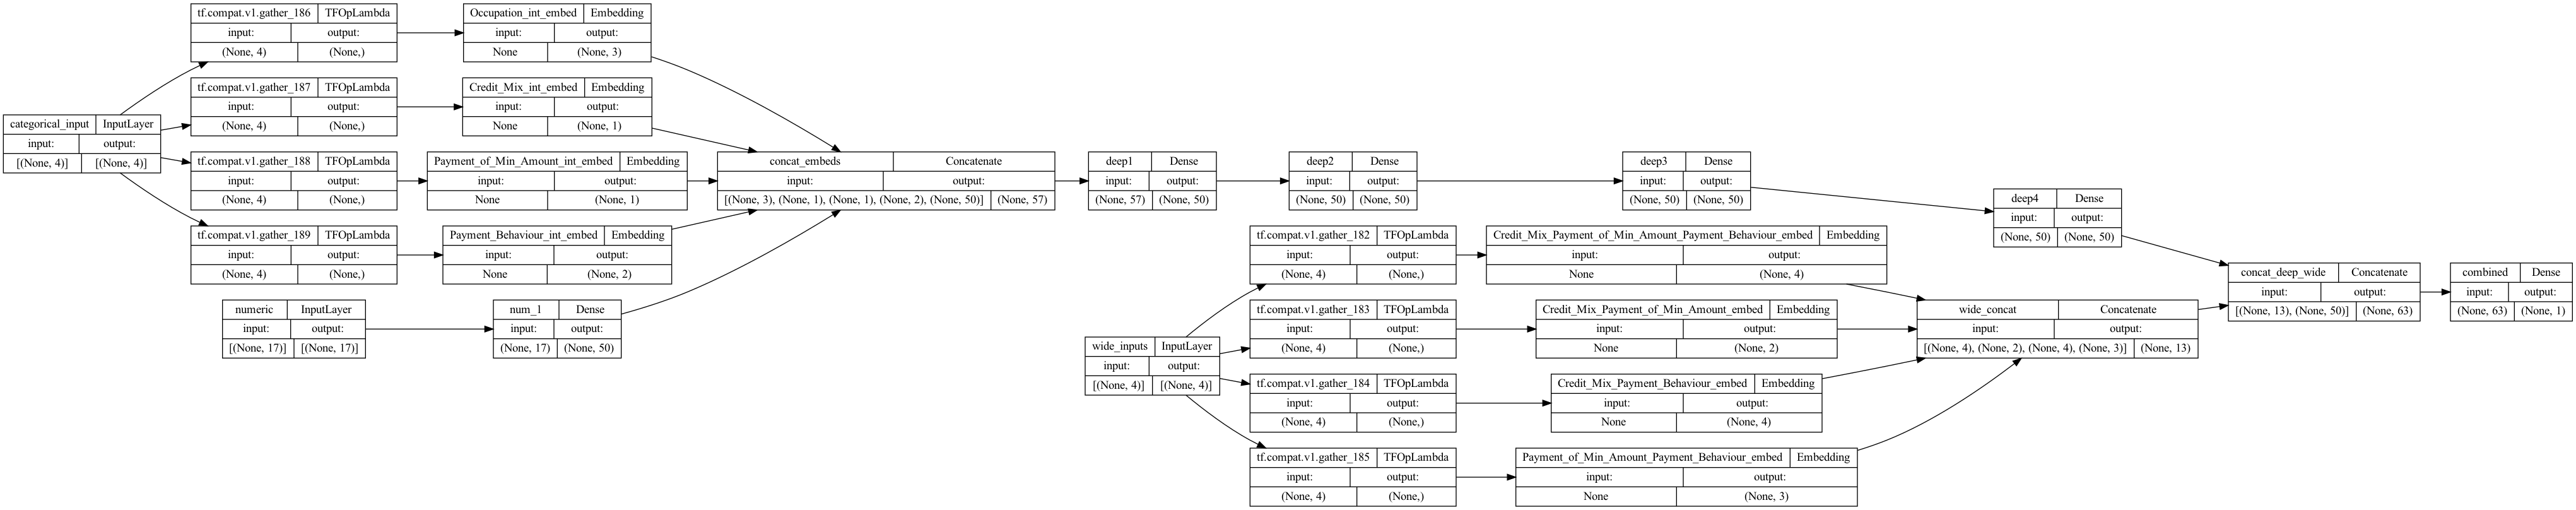

In [323]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [324]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
781/781 [==============================] - 2s 1ms/step - loss: 0.2334 - precision_25: 0.7111 - val_loss: 0.2149 - val_precision_25: 0.7198
Epoch 2/20
781/781 [==============================] - 1s 1ms/step - loss: 0.2026 - precision_25: 0.7199 - val_loss: 0.1922 - val_precision_25: 0.7198
Epoch 3/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1859 - precision_25: 0.7199 - val_loss: 0.1802 - val_precision_25: 0.7198
Epoch 4/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1764 - precision_25: 0.7199 - val_loss: 0.1723 - val_precision_25: 0.7198
Epoch 5/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1695 - precision_25: 0.7199 - val_loss: 0.1661 - val_precision_25: 0.7200
Epoch 6/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1641 - precision_25: 0.7290 - val_loss: 0.1613 - val_precision_25: 0.7477
Epoch 7/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1600 - precision_25: 0.7

In [325]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

196/196 [==============================] - 0s 670us/step
[[1066  683]
 [ 572 3922]]
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      1749
           1       0.85      0.87      0.86      4494

    accuracy                           0.80      6243
   macro avg       0.75      0.74      0.75      6243
weighted avg       0.80      0.80      0.80      6243



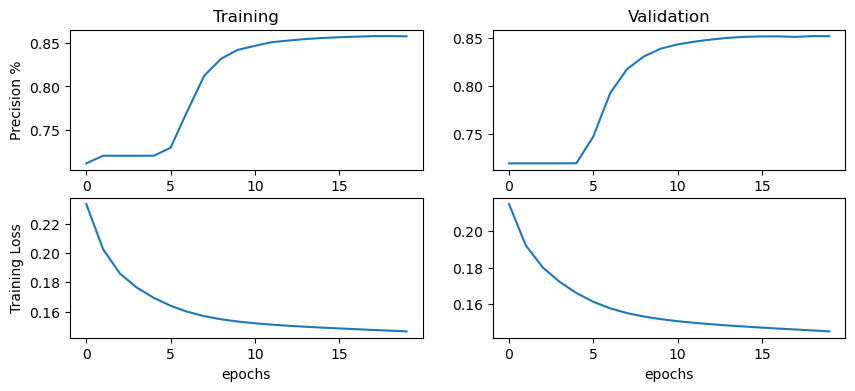

In [326]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_25'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_25'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

#### Removing one of the layers

In [327]:
X_train_crossed = X_train[cross_col_df_names].to_numpy()
X_test_crossed = X_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = X_train[categorical_vars_ints].to_numpy() 
X_test_cat = X_test[categorical_vars_ints].to_numpy() 

# and save off the numeric features
X_train_num =  X_train[numerical_vars].to_numpy()
X_test_num = X_test[numerical_vars].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_vars_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=50, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [328]:
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 4)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_194 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                                  
 tf.compat.v1.gather_195 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                           

                                                                                                  
 combined (Dense)               (None, 1)            64          ['concat_deep_wide[0][0]']       
                                                                                                  
Total params: 6,688
Trainable params: 6,688
Non-trainable params: 0
__________________________________________________________________________________________________


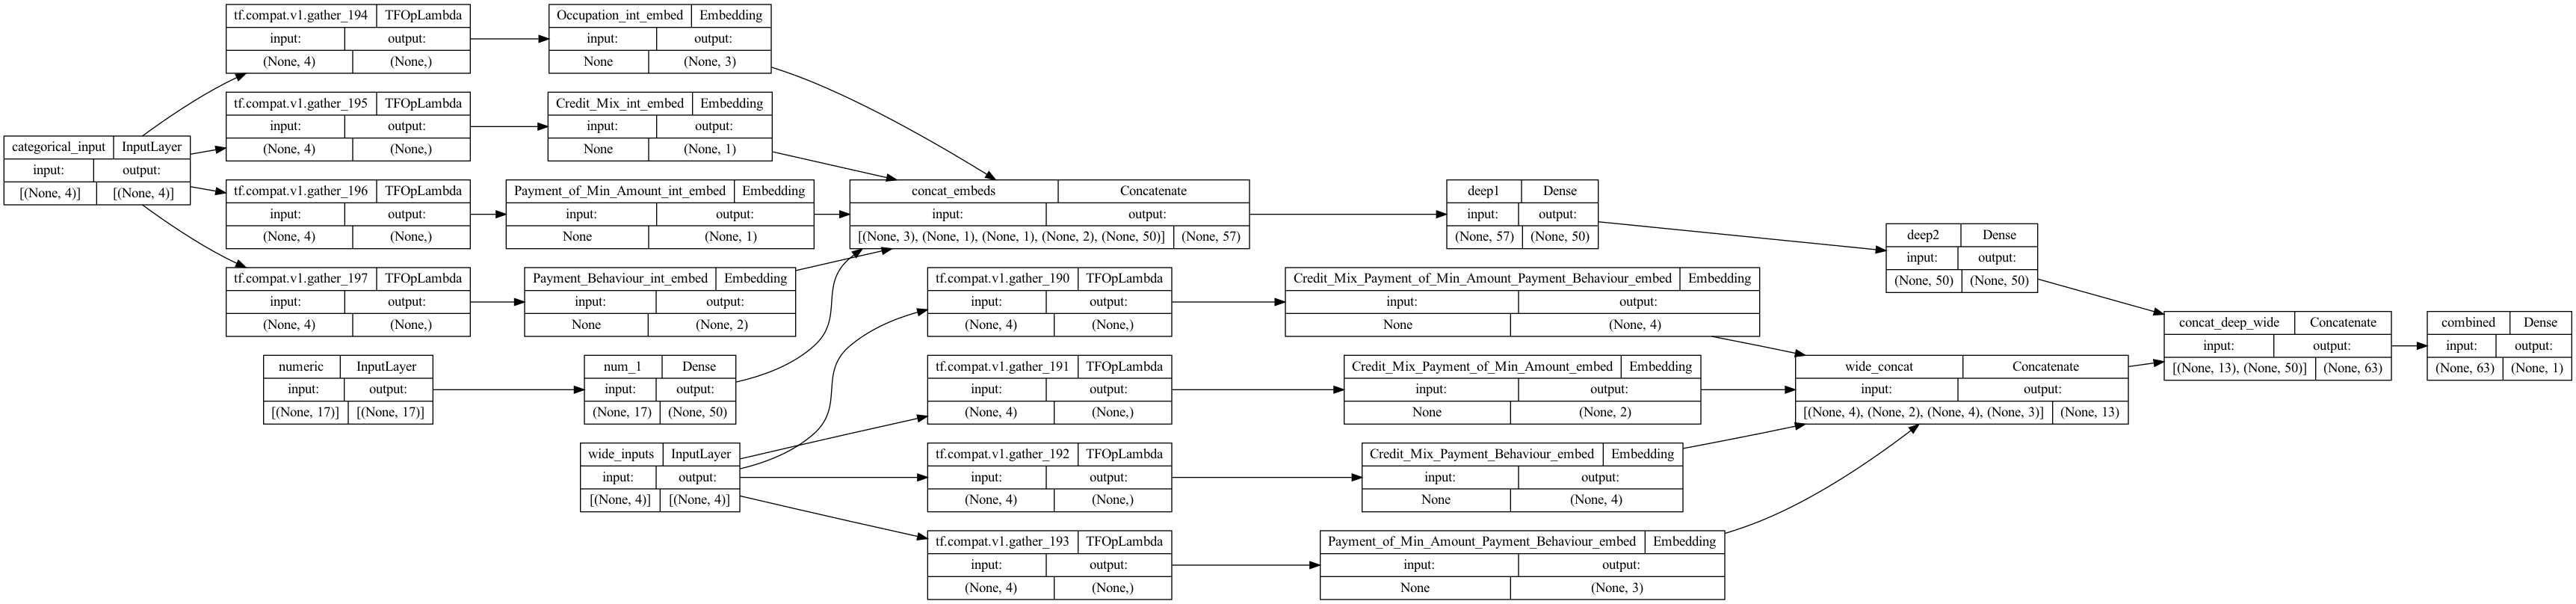

In [329]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [330]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
781/781 [==============================] - 2s 1ms/step - loss: 0.2095 - precision_26: 0.7230 - val_loss: 0.1898 - val_precision_26: 0.7214
Epoch 2/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1811 - precision_26: 0.7326 - val_loss: 0.1734 - val_precision_26: 0.7468
Epoch 3/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1694 - precision_26: 0.7662 - val_loss: 0.1650 - val_precision_26: 0.7813
Epoch 4/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1633 - precision_26: 0.7958 - val_loss: 0.1603 - val_precision_26: 0.8011
Epoch 5/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1597 - precision_26: 0.8111 - val_loss: 0.1574 - val_precision_26: 0.8111
Epoch 6/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1574 - precision_26: 0.8187 - val_loss: 0.1554 - val_precision_26: 0.8179
Epoch 7/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1557 - precision_26: 0.8

In [331]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

196/196 [==============================] - 0s 656us/step
[[ 941  808]
 [ 423 4071]]
              precision    recall  f1-score   support

           0       0.69      0.54      0.60      1749
           1       0.83      0.91      0.87      4494

    accuracy                           0.80      6243
   macro avg       0.76      0.72      0.74      6243
weighted avg       0.79      0.80      0.79      6243



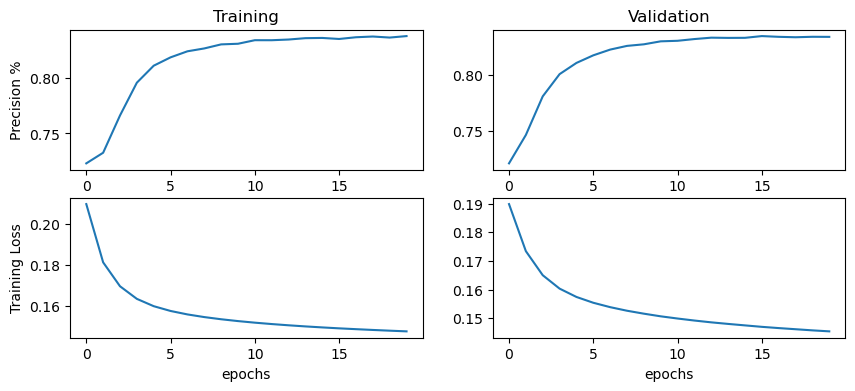

In [332]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_26'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_26'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

#### Adding more layers to find the best number

After many trials and errors, we find that the number of layers that perform superiorly is 7 layers.

In [354]:
"""WE CAN DO THIS IN A BETTER AND MORE PROGRAMMABLE WAY USING FUNCTIONS AND CROSS VALIDATION SCORES IF WE HAVE TIME"""

'WE CAN DO THIS IN A BETTER AND MORE PROGRAMMABLE WAY USING FUNCTIONS AND CROSS VALIDATION SCORES IF WE HAVE TIME'

In [333]:
X_train_crossed = X_train[cross_col_df_names].to_numpy()
X_test_crossed = X_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = X_train[categorical_vars_ints].to_numpy() 
X_test_cat = X_test[categorical_vars_ints].to_numpy() 

# and save off the numeric features
X_train_num =  X_train[numerical_vars].to_numpy()
X_test_num = X_test[numerical_vars].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_vars_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=50, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep4')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep5')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep6')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep7')(deep_branch)


    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [334]:
model.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 4)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_202 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                                  
 tf.compat.v1.gather_203 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                           

                                                                 t_embed[0][0]',                  
                                                                  'Credit_Mix_Payment_Behaviour_em
                                                                 bed[0][0]',                      
                                                                  'Payment_of_Min_Amount_Payment_B
                                                                 ehaviour_embed[0][0]']           
                                                                                                  
 deep7 (Dense)                  (None, 50)           2550        ['deep6[0][0]']                  
                                                                                                  
 concat_deep_wide (Concatenate)  (None, 63)          0           ['wide_concat[0][0]',            
                                                                  'deep7[0][0]']                  
          

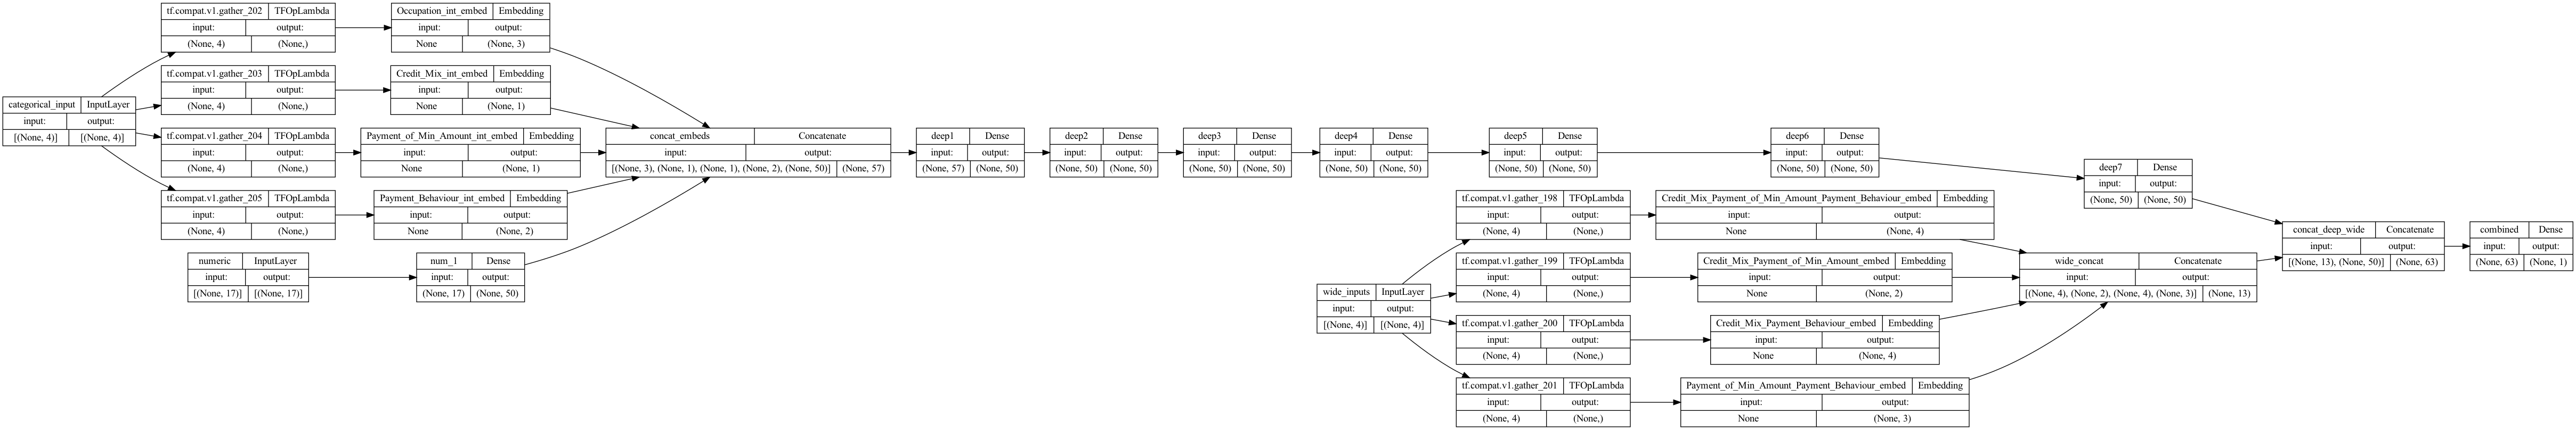

In [335]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [336]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
781/781 [==============================] - 2s 2ms/step - loss: 0.2307 - precision_27: 0.7197 - val_loss: 0.2187 - val_precision_27: 0.7198
Epoch 2/20
781/781 [==============================] - 1s 1ms/step - loss: 0.2091 - precision_27: 0.7199 - val_loss: 0.2001 - val_precision_27: 0.7198
Epoch 3/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1926 - precision_27: 0.7199 - val_loss: 0.1858 - val_precision_27: 0.7198
Epoch 4/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1805 - precision_27: 0.7199 - val_loss: 0.1760 - val_precision_27: 0.7198
Epoch 5/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1725 - precision_27: 0.7199 - val_loss: 0.1698 - val_precision_27: 0.7198
Epoch 6/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1674 - precision_27: 0.7199 - val_loss: 0.1657 - val_precision_27: 0.7198
Epoch 7/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1639 - precision_27: 0.7

In [337]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

196/196 [==============================] - 0s 683us/step
[[1128  621]
 [ 612 3882]]
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      1749
           1       0.86      0.86      0.86      4494

    accuracy                           0.80      6243
   macro avg       0.76      0.75      0.75      6243
weighted avg       0.80      0.80      0.80      6243



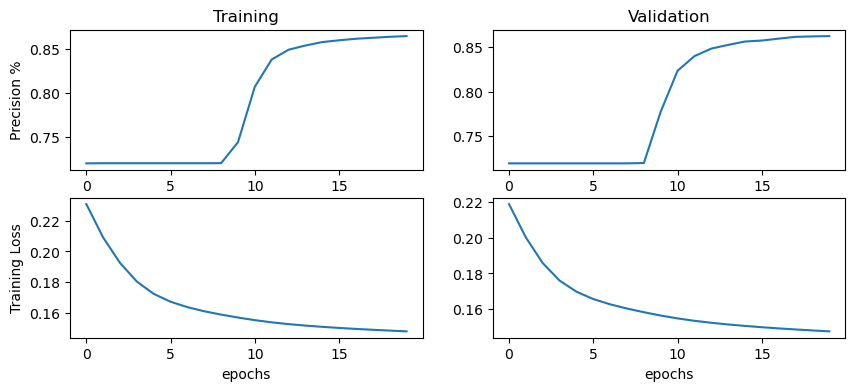

In [338]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_27'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_27'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

[1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). 

### Comparing the performance to just the Deep network

Thus, deleting the wide part and then evaluating:

In [339]:
X_train_crossed = X_train[cross_col_df_names].to_numpy()
X_test_crossed = X_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = X_train[categorical_vars_ints].to_numpy() 
X_test_cat = X_test[categorical_vars_ints].to_numpy() 

# and save off the numeric features
X_train_num =  X_train[numerical_vars].to_numpy()
X_test_num = X_test[numerical_vars].to_numpy()

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_vars_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=50, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep4')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep5')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep6')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep7')(deep_branch)
    
# merge the deep and wide branch
final_branch = deep_branch
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [340]:
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 4)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_206 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                                  
 tf.compat.v1.gather_207 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                           

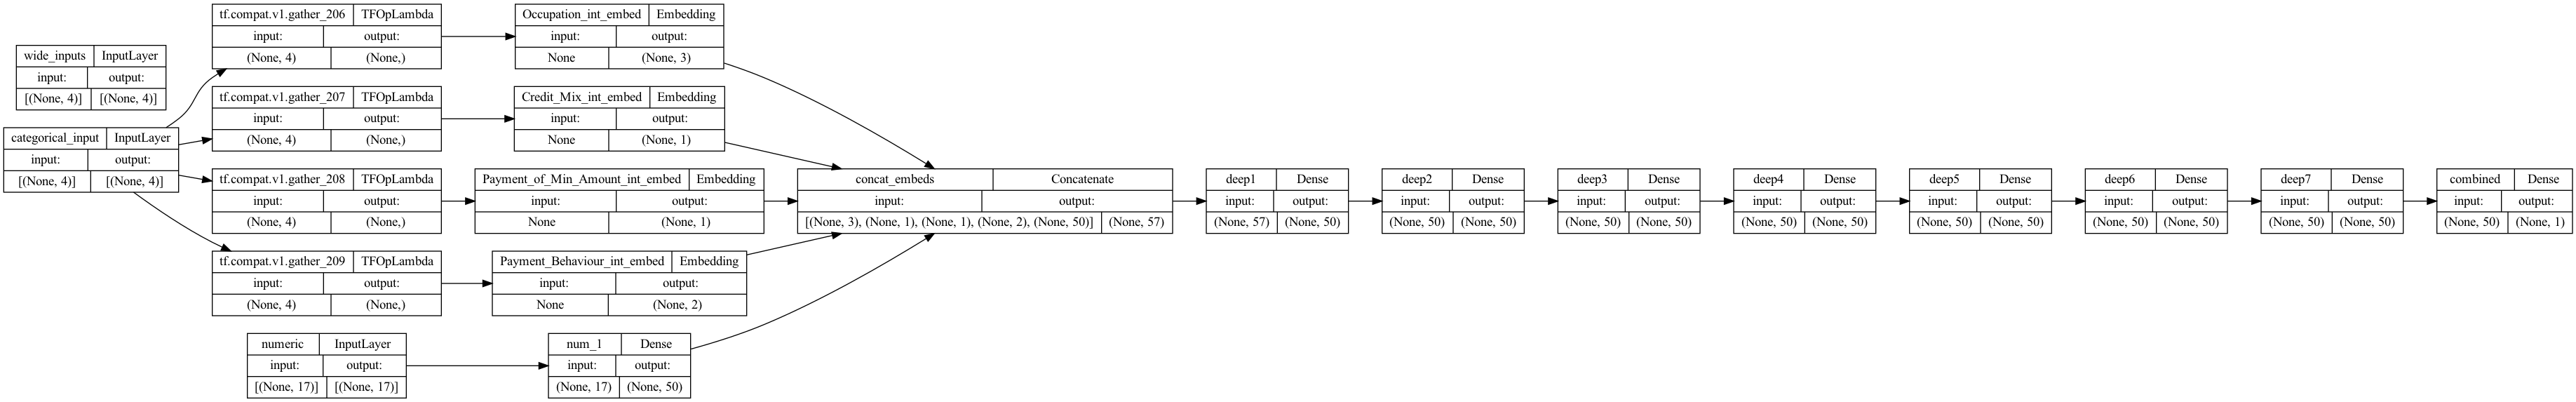

In [341]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [342]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
781/781 [==============================] - 2s 2ms/step - loss: 0.2370 - precision_28: 0.7183 - val_loss: 0.2236 - val_precision_28: 0.7200
Epoch 2/20
781/781 [==============================] - 1s 1ms/step - loss: 0.2132 - precision_28: 0.7199 - val_loss: 0.2036 - val_precision_28: 0.7198
Epoch 3/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1967 - precision_28: 0.7199 - val_loss: 0.1904 - val_precision_28: 0.7198
Epoch 4/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1851 - precision_28: 0.7199 - val_loss: 0.1799 - val_precision_28: 0.7198
Epoch 5/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1754 - precision_28: 0.7199 - val_loss: 0.1711 - val_precision_28: 0.7198
Epoch 6/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1682 - precision_28: 0.7199 - val_loss: 0.1654 - val_precision_28: 0.7198
Epoch 7/20
781/781 [==============================] - 1s 1ms/step - loss: 0.1636 - precision_28: 0.7

In [343]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

196/196 [==============================] - 0s 668us/step
[[1112  637]
 [ 605 3889]]
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      1749
           1       0.86      0.87      0.86      4494

    accuracy                           0.80      6243
   macro avg       0.75      0.75      0.75      6243
weighted avg       0.80      0.80      0.80      6243



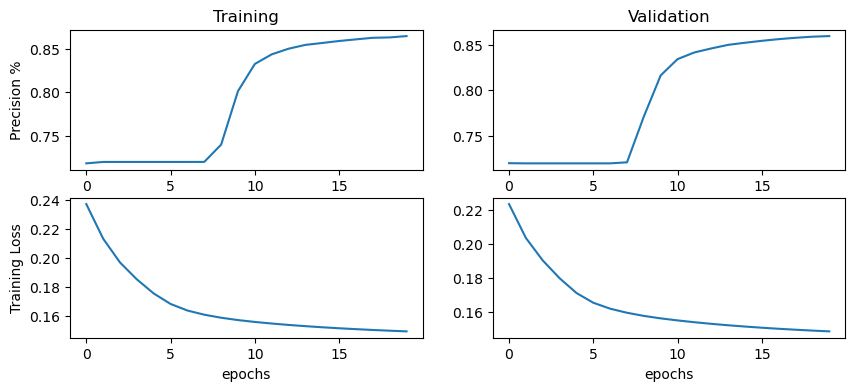

In [344]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_28'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_28'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

Thus, comparing our Deep and Wide network with 7 dense layers to this nearly multi-perceptron network with 7 layers, we can see that our wide network performs a bit better, not drastically better though.

## Exceptional Work

### Additional Analyses

We try to change the number of hidden units and see what might happen, maybe also change the optimizer.

In [345]:
# now let's create some different crossed values
cross_columns = [['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour'],
                 ['Credit_Mix','Payment_of_Min_Amount'],
                 ['Credit_Mix','Payment_Behaviour'],
                 ['Payment_of_Min_Amount','Payment_Behaviour']
                ]


# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = X_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # Save the encoder used here for later:
    encoders[cross_col_name] = enc
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

['Credit_Mix_Payment_of_Min_Amount_Payment_Behaviour',
 'Credit_Mix_Payment_of_Min_Amount',
 'Credit_Mix_Payment_Behaviour',
 'Payment_of_Min_Amount_Payment_Behaviour']

In [346]:
X_train_crossed = X_train[cross_col_df_names].to_numpy()
X_test_crossed = X_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = X_train[categorical_vars_ints].to_numpy() 
X_test_cat = X_test[categorical_vars_ints].to_numpy() 

# and save off the numeric features
X_train_num =  X_train[numerical_vars].to_numpy()
X_test_num = X_test[numerical_vars].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_vars_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=50, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=70,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=60,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=40,activation='relu', name='deep4')(deep_branch)
deep_branch = Dense(units=30,activation='relu', name='deep5')(deep_branch)
deep_branch = Dense(units=20,activation='relu', name='deep6')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep7')(deep_branch)

    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [347]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 4)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_214 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                                  
 tf.compat.v1.gather_215 (TFOpL  (None,)             0           ['categorical_input[0][0]']      
 ambda)                                                                                           
                                                                                           

                                                                 t_embed[0][0]',                  
                                                                  'Credit_Mix_Payment_Behaviour_em
                                                                 bed[0][0]',                      
                                                                  'Payment_of_Min_Amount_Payment_B
                                                                 ehaviour_embed[0][0]']           
                                                                                                  
 deep7 (Dense)                  (None, 10)           210         ['deep6[0][0]']                  
                                                                                                  
 concat_deep_wide (Concatenate)  (None, 23)          0           ['wide_concat[0][0]',            
                                                                  'deep7[0][0]']                  
          

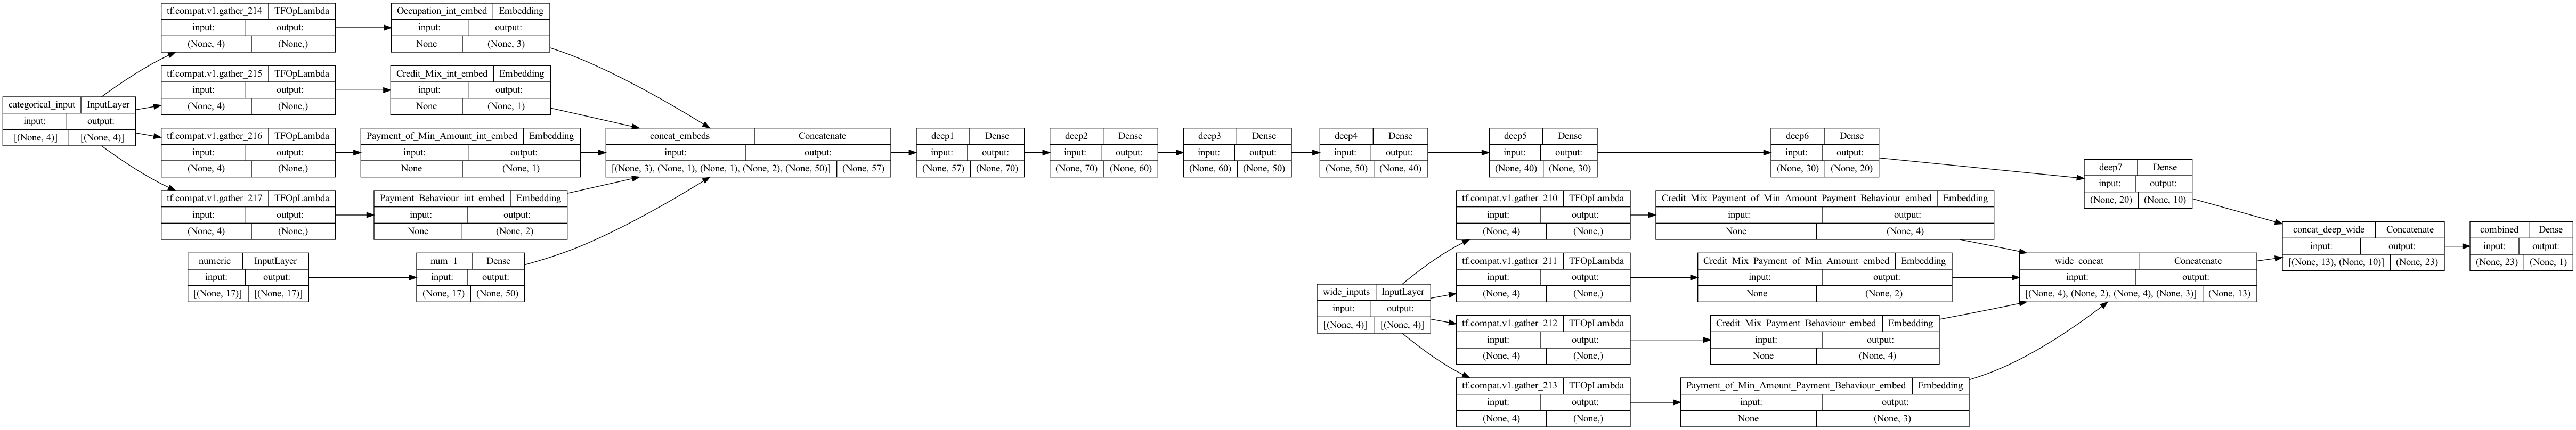

In [348]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [349]:
%%time

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
781/781 [==============================] - 2s 2ms/step - loss: 0.1417 - precision_29: 0.8383 - val_loss: 0.1293 - val_precision_29: 0.8444
Epoch 2/20
781/781 [==============================] - 1s 2ms/step - loss: 0.1297 - precision_29: 0.8522 - val_loss: 0.1267 - val_precision_29: 0.8568
Epoch 3/20
781/781 [==============================] - 1s 2ms/step - loss: 0.1271 - precision_29: 0.8546 - val_loss: 0.1303 - val_precision_29: 0.8680
Epoch 4/20
781/781 [==============================] - 1s 2ms/step - loss: 0.1253 - precision_29: 0.8579 - val_loss: 0.1243 - val_precision_29: 0.8655
Epoch 5/20
781/781 [==============================] - 1s 2ms/step - loss: 0.1239 - precision_29: 0.8599 - val_loss: 0.1237 - val_precision_29: 0.8647
Epoch 6/20
781/781 [==============================] - 1s 2ms/step - loss: 0.1230 - precision_29: 0.8591 - val_loss: 0.1248 - val_precision_29: 0.8673
Epoch 7/20
781/781 [==============================] - 1s 2ms/step - loss: 0.1217 - precision_29: 0.8

In [350]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

196/196 [==============================] - 0s 692us/step
[[1174  575]
 [ 425 4069]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1749
           1       0.88      0.91      0.89      4494

    accuracy                           0.84      6243
   macro avg       0.81      0.79      0.80      6243
weighted avg       0.84      0.84      0.84      6243



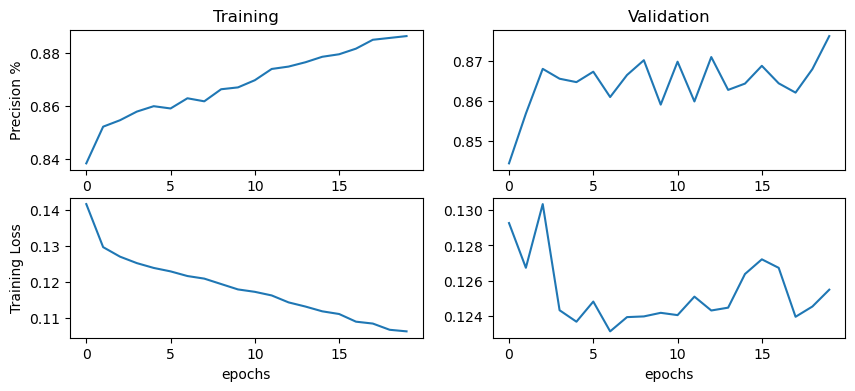

In [351]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_29'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_29'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

One idea (required for 7000 level students): For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models.

## Using ROC curve and AUC

We put our network in functions in order for us to put in the code that plots the ROC curve and also we Scikit wrapper around it to be able to put into cross_val_score and get scores.

In [175]:
"""Putting the network in functions"""
def create_network(X_train, y_train, X_test, y_test):
    X_train_crossed = X_train[cross_col_df_names].to_numpy()
    X_test_crossed = X_test[cross_col_df_names].to_numpy()

    # save categorical features
    X_train_cat = X_train[categorical_vars_ints].to_numpy() 
    X_test_cat = X_test[categorical_vars_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  X_train[numerical_vars].to_numpy()
    X_test_num = X_test[numerical_vars].to_numpy()


    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):

        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
        N = len(encoders[col].classes_)
        N_reduced = int(np.sqrt(N))


        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)

        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=N_reduced, 
                      input_length=1, name=col+'_embed')(x)

        # save these outputs to concatenate later
        crossed_outputs.append(x)


    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_vars_ints):

        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(X_train[col].max(),X_test[col].max())+1
        N_reduced = int(np.sqrt(N))

        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)

        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=N_reduced, 
                      input_length=1, name=col+'_embed')(x)

        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)

    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=50, activation='relu',name='num_1')(input_num)

    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep4')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep5')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep6')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep7')(deep_branch)



    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                               name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                         name='combined')(final_branch)

    model = Model(inputs=[input_crossed,input_cat,input_num], 
                  outputs=final_branch)
    return model

def fit(model, X_train, y_train, X_test, y_test):
    X_train_crossed = X_train[cross_col_df_names].to_numpy()
    X_test_crossed = X_test[cross_col_df_names].to_numpy()

    # save categorical features
    X_train_cat = X_train[categorical_vars_ints].to_numpy() 
    X_test_cat = X_test[categorical_vars_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  X_train[numerical_vars].to_numpy()
    X_test_num = X_test[numerical_vars].to_numpy()

    model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

    # lets also add the history variable to see how we are doing
    # and lets add a validation set to keep track of our progress
    history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                        y_train, 
                        epochs=5, 
                        batch_size=32, 
                        verbose=1, 
                        validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))
    return history

def predict(model, X_train, y_train, X_test, y_test):
    X_train_crossed = X_train[cross_col_df_names].to_numpy()
    X_test_crossed = X_test[cross_col_df_names].to_numpy()

    # save categorical features
    X_train_cat = X_train[categorical_vars_ints].to_numpy() 
    X_test_cat = X_test[categorical_vars_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  X_train[numerical_vars].to_numpy()
    X_test_num = X_test[numerical_vars].to_numpy()

    yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))
    return

In [176]:
#Trying to model using the function
model = create_network(X_train, y_train, X_test, y_test)

In [177]:
#Trying to fit using the function
history = fit(model, X_train, y_train, X_test, y_test)

Epoch 1/5
781/781 [==============================] - 2s 2ms/step - loss: 0.1430 - precision_20: 0.8368 - val_loss: 0.1303 - val_precision_20: 0.8470
Epoch 2/5
781/781 [==============================] - 1s 2ms/step - loss: 0.1307 - precision_20: 0.8487 - val_loss: 0.1291 - val_precision_20: 0.8520
Epoch 3/5
781/781 [==============================] - 1s 2ms/step - loss: 0.1276 - precision_20: 0.8553 - val_loss: 0.1262 - val_precision_20: 0.8659
Epoch 4/5
781/781 [==============================] - 1s 2ms/step - loss: 0.1257 - precision_20: 0.8572 - val_loss: 0.1239 - val_precision_20: 0.8604
Epoch 5/5
781/781 [==============================] - 1s 2ms/step - loss: 0.1245 - precision_20: 0.8592 - val_loss: 0.1244 - val_precision_20: 0.8554


In [178]:
#Trying to predict using the function
predict(model, X_train, y_train, X_test, y_test)

196/196 [==============================] - 0s 670us/step
[[1043  706]
 [ 316 4178]]
              precision    recall  f1-score   support

           0       0.77      0.60      0.67      1749
           1       0.86      0.93      0.89      4494

    accuracy                           0.84      6243
   macro avg       0.81      0.76      0.78      6243
weighted avg       0.83      0.84      0.83      6243



In [355]:
"""CANT WORK ON THE ERROR BECAUSE WE RAN OUT OF TIME, BUT WE KNOW ITS BECAUSE 
WE NEED TO MANIPULATE THE FUNCTION TO WORK WITH INDICES THAN PANDAS DATAFRAMES"""

'CANT WORK ON THE ERROR BECAUSE WE RAN OUT OF TIME, BUT WE KNOW ITS BECAUSE \nWE NEED TO MANIPULATE THE FUNCTION TO WORK WITH INDICES THAN PANDAS DATAFRAMES'

In [229]:
"""Buildin the ROC Curve and AUC"""
from sklearn.metrics import roc_curve, auc
from scipy import interp

K = 10

if sklearn_version < '0.18':
    from sklearn.cross_validation import StratifiedKFold
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=K,
                            random_state=1)
else:
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits=K,
                            shuffle=True,
                            random_state=1).split(X_train, y_train)
    

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

model = create_network(X_train, y_train, X_test, y_test)
for i, (train, test) in enumerate(kfold):
    history = fit(model, X_train, y_train, X_test, y_test)

    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()

/var/folders/l3/2httnx650539mb_cn3qm_z80cc_3b_/T/ipykernel_33073/432206921.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_train_crossed = X_train[cross_col_df_names].to_numpy()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [209]:
"""Building the scikit wrapper around the keras model"""
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=10, 
                                 batch_size=100, 
                                 verbose=0)

### Doing Statistical Comparison

In [356]:
"""SHOULD BE AN EASY IMPLEMENTATION BUT IT DEPENDS ON FIXING THE FUNCTION IN THE STEP BEFORE,
UNFORTUNATELY IT IS THE DEADLINE NOW :)"""

'SHOULD BE AN EASY IMPLEMENTATION BUT IT DEPENDS ON FIXING THE FUNCTION IN THE STEP BEFORE,\nUNFORTUNATELY IT IS THE DEADLINE NOW :)'

In [ ]:
clf1 = neural_network(#adding our modification here)
clf2 = neural_network(#adding our modification here)
clf3 = neural_network(#adding our modification here)

train_size = 0.003 # small training size
cv = StratifiedShuffleSplit(n_splits=10,train_size=train_size,test_size=1-train_size)

evals1 = cross_val_score(estimator=clf1,X=X,y=y,scoring=my_scorer,cv=cv)
evals2 = cross_val_score(estimator=clf2,X=X,y=y,scoring=my_scorer,cv=cv)
evals3 = cross_val_score(estimator=clf3,X=X,y=y,scoring=my_scorer,cv=cv)

t = 2.26 / np.sqrt(10)
e1 = (1-evals1)-(1-evals2)
e2 = (1-evals2)-(1-evals3)
stdtot1 = np.std(e1)
stdtot2 = np.std(e2)

dbar1 = np.mean(e1)
dbar2 = np.mean(e2)
print('Range 1:', dbar1-t*stdtot1, dbar1+t*stdtot1)
print('Range 2:', dbar2-t*stdtot2, dbar2+t*stdtot2)